# Credit card default propensity prediction

__Objective__ – Predict the probability of a customer defaulting payment for the credit card the subsequent month, based on past information. The past information is provided in the dataset. This probability will help the collections team to prioritise follow up with customers who have a high propensity of defaulting.

## Project instructions
1.	Perform the required data pre-processing to treat for missing values and outliers
2.	Perform exploratory data analysis to visualise the spread of each of the X variables and the relationship between the various X variables and the Y variable
3.	Identify any multi-collinearity and perform dimensionality reduction like PCA if required
4.	Use the original X variables or the components from PCA & divide the given data into train and test sets
5.	Build a model to predict the default propensity of a customer
6.	Evaluate the model based on model performance measures for classification and recommend the most suitable model.
7.	Come up with recommendations / actionable insights based on feature importance scores derived from the model.


## About the dataset
The dataset contains the following information of 30000 customers:
1.	__DEFAULT__ - Default payment next month (Yes=1, No=0)
2.	__LIMIT_BAL__ - Amount of the given credit (INR)  
3.	__SEX__ - Gender (1 = male; 2 = female)
4.	__EDUCATION__ - Education (1 = graduate school; 2 = university; 3 = high school; 4 = others)
5.	__MARRIAGE__ - (1 = married; 2 = single; 3 = others)
6.	__AGE__ - (year)
7.	__PAST_PAY__ - History of repayment status
    <br> -  PAST_PAY1 = the repayment status in September 2005
    <br> -  PAST_PAY2 = the repayment status in August 2005
    <br> -  PAST_PAY6 = the repayment status in April 2005
    <br> -  The measurement scale for the repayment status is 
         i.  -1 = pay duly <br>
        ii.	 1 = payment delay for one month<br>
        iii. 2 = payment delay for two months <br>
        iv.	 8 = payment delay for eight months<br>
        v.	 9 = payment delay for nine months and above <br>
8.	__BILL_AMT__- Amount of bill statement (INR)
    <br> -  BILL_AMT1 = amount of bill statement in September 2005
    <br> -  BILL_AMT2 = amount of bill statement in August 2005
    <br> -  BILL_AMT6 = amount of bill statement in April 2005
9.	__PAY_AMT__ - Amount of previous payment (INR)
    <br> -  PAY_AMT1 = amount paid in September 2005
    <br> -  PAY_AMT2 = amount paid in August 2005
    <br> -  PAY_AMT6 = amount paid in April 2005


# Additional information
1.	The difference between the bill amount and the past pay for a month will give an indication of the pending amount for each month and can be used as an additional X variable
2.	The average / sum of bill amount can be used as an additional X variable which will give an indication on the customer value.


In [1]:
#Importing Important Libraries
import pandas            as pd
import numpy             as np
import matplotlib.pyplot as plt
import seaborn           as sns
import statsmodels.api   as sm
import scipy.stats       as stats
import lightgbm          as lgb
import datetime          as dt
import matplotlib
import pydotplus

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline


from math                      import sqrt

from sklearn.datasets          import load_boston
from sklearn.model_selection   import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import RFE
from sklearn.linear_model      import LinearRegression, LogisticRegression
from sklearn.linear_model      import RidgeCV, LassoCV, Ridge, Lasso
from sklearn.linear_model      import ElasticNetCV, ElasticNet
from sklearn.metrics           import mean_squared_error
from sklearn.metrics           import r2_score, roc_auc_score, roc_curve
from sklearn.metrics           import confusion_matrix, accuracy_score, classification_report
from sklearn.tree              import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from sklearn.externals.six     import StringIO
from sklearn.preprocessing     import StandardScaler
from sklearn.ensemble          import RandomForestClassifier, VotingClassifier
from sklearn.neighbors         import KNeighborsClassifier,KNeighborsRegressor
from sklearn.naive_bayes       import BernoulliNB
from sklearn.svm               import SVC, SVR
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster           import KMeans, AgglomerativeClustering
from sklearn.feature_selection import RFECV

from collections               import Counter as count

from IPython.display           import Image

from scipy.stats               import randint as sp_randint
from scipy.cluster.hierarchy   import dendrogram, linkage

from statsmodels.stats.outliers_influence import variance_inflation_factor

from imblearn.over_sampling    import SMOTE

from category_encoders         import TargetEncoder

from scipy.stats               import ttest_1samp,ttest_ind, wilcoxon

from statsmodels.stats.power   import ttest_power

from mlxtend.feature_selection import SequentialFeatureSelector as sfs



In [2]:
#Loading the dataset
df = pd.read_csv('credit_card.csv')
df.sample(10)

ID  LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_1  PAY_2  PAY_3  \
19700  19701      50000    2          3         1   39      0      0      0   
3455    3456      50000    1          2         1   37      0      0      0   
22916  22917     300000    2          1         1   35     -1     -1     -2   
29183  29184      30000    1          1         2   30      0      0      0   
20623  20624     100000    1          1         2   32      0      0      0   
4870    4871     260000    2          1         2   29     -1     -1     -1   
29229  29230      50000    1          2         2   24      0      0      0   
13670  13671     320000    1          1         1   40     -1     -1     -1   
26052  26053     140000    2          2         2   38      0      0      0   
27204  27205     130000    1          3         1   39      0     -1     -1   

       PAY_4  ...  BILL_AMT4  BILL_AMT5  BILL_AMT6  PAY_AMT1  PAY_AMT2  \
19700      0  ...      43739      29090      24317      1803      2060   
3455       0  ...      28914      29529      29319      2000      1435   
22916     -2  ...          0          0        477         0         0   
29183      0  ...      25991      25429      26234      1780      1752   
20623     -2  ...       -732      -1782      -2250      1000         0   
4870      -1  ...        507       3787       1443         0      4873   
29229      0  ...      22067      22896      23873      1323      1654   
13670     -1  ...        430        430        430       430       430   
26052      0  ...     123208      97154      97687      4729      5434   
27204     -1  ...        390        390        390       390       390   

       PAY_AMT3  PAY_AMT4  PAY_AMT5  PAY_AMT6  DEFAULT  
19700      2025      1375      1035       900        0  
3455       1149      1197      1009       990        0  
22916         0         0       477       348        0  
29183      1666       800      1161      3128        0  
20623      1732      1268      2000      3500        0  
4870        507      3787      1443         0        1  
29229      1700      1500      1500      1000        0  
13670       430       430       430       430        0  
26052      4751      3500      3500      3800        0  
27204       390       390       390       390        0  

[10 rows x 25 columns]

df.dtypes(include='object')

In [3]:
#Finding number of Rows and columns
df.shape

(30000, 25)

In [4]:
#To find data types of each rows and to find is there are missing values present
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
ID           30000 non-null int64
LIMIT_BAL    30000 non-null int64
SEX          30000 non-null int64
EDUCATION    30000 non-null int64
MARRIAGE     30000 non-null int64
AGE          30000 non-null int64
PAY_1        30000 non-null int64
PAY_2        30000 non-null int64
PAY_3        30000 non-null int64
PAY_4        30000 non-null int64
PAY_5        30000 non-null int64
PAY_6        30000 non-null int64
BILL_AMT1    30000 non-null int64
BILL_AMT2    30000 non-null int64
BILL_AMT3    30000 non-null int64
BILL_AMT4    30000 non-null int64
BILL_AMT5    30000 non-null int64
BILL_AMT6    30000 non-null int64
PAY_AMT1     30000 non-null int64
PAY_AMT2     30000 non-null int64
PAY_AMT3     30000 non-null int64
PAY_AMT4     30000 non-null int64
PAY_AMT5     30000 non-null int64
PAY_AMT6     30000 non-null int64
DEFAULT      30000 non-null int64
dtypes: int64(25)
memory usage: 5.7 MB


### There are no Null Values and all the Variables are in as Int.

# Descriptive Statistics

In [5]:
#To find five point summary
df.describe().T

count           mean            std       min       25%  \
ID         30000.0   15000.500000    8660.398374       1.0   7500.75   
LIMIT_BAL  30000.0  167484.322667  129747.661567   10000.0  50000.00   
SEX        30000.0       1.603733       0.489129       1.0      1.00   
EDUCATION  30000.0       1.853133       0.790349       0.0      1.00   
MARRIAGE   30000.0       1.551867       0.521970       0.0      1.00   
AGE        30000.0      35.485500       9.217904      21.0     28.00   
PAY_1      30000.0      -0.016700       1.123802      -2.0     -1.00   
PAY_2      30000.0      -0.133767       1.197186      -2.0     -1.00   
PAY_3      30000.0      -0.166200       1.196868      -2.0     -1.00   
PAY_4      30000.0      -0.220667       1.169139      -2.0     -1.00   
PAY_5      30000.0      -0.266200       1.133187      -2.0     -1.00   
PAY_6      30000.0      -0.291100       1.149988      -2.0     -1.00   
BILL_AMT1  30000.0   51223.330900   73635.860576 -165580.0   3558.75   
BILL_AMT2  30000.0   49179.075167   71173.768783  -69777.0   2984.75   
BILL_AMT3  30000.0   47013.154800   69349.387427 -157264.0   2666.25   
BILL_AMT4  30000.0   43262.948967   64332.856134 -170000.0   2326.75   
BILL_AMT5  30000.0   40311.400967   60797.155770  -81334.0   1763.00   
BILL_AMT6  30000.0   38871.760400   59554.107537 -339603.0   1256.00   
PAY_AMT1   30000.0    5663.580500   16563.280354       0.0   1000.00   
PAY_AMT2   30000.0    5921.163500   23040.870402       0.0    833.00   
PAY_AMT3   30000.0    5225.681500   17606.961470       0.0    390.00   
PAY_AMT4   30000.0    4826.076867   15666.159744       0.0    296.00   
PAY_AMT5   30000.0    4799.387633   15278.305679       0.0    252.50   
PAY_AMT6   30000.0    5215.502567   17777.465775       0.0    117.75   
DEFAULT    30000.0       0.221200       0.415062       0.0      0.00   

                50%        75%        max  
ID          15000.5   22500.25    30000.0  
LIMIT_BAL  140000.0  240000.00  1000000.0  
SEX             2.0       2.00        2.0  
EDUCATION       2.0       2.00        6.0  
MARRIAGE        2.0       2.00        3.0  
AGE            34.0      41.00       79.0  
PAY_1           0.0       0.00        8.0  
PAY_2           0.0       0.00        8.0  
PAY_3           0.0       0.00        8.0  
PAY_4           0.0       0.00        8.0  
PAY_5           0.0       0.00        8.0  
PAY_6           0.0       0.00        8.0  
BILL_AMT1   22381.5   67091.00   964511.0  
BILL_AMT2   21200.0   64006.25   983931.0  
BILL_AMT3   20088.5   60164.75  1664089.0  
BILL_AMT4   19052.0   54506.00   891586.0  
BILL_AMT5   18104.5   50190.50   927171.0  
BILL_AMT6   17071.0   49198.25   961664.0  
PAY_AMT1     2100.0    5006.00   873552.0  
PAY_AMT2     2009.0    5000.00  1684259.0  
PAY_AMT3     1800.0    4505.00   896040.0  
PAY_AMT4     1500.0    4013.25   621000.0  
PAY_AMT5     1500.0    4031.50   426529.0  
PAY_AMT6     1500.0    4000.00   528666.0  
DEFAULT         0.0       0.00        1.0

Inference:
    - There are around 30000 distict credit card clients.
    - The average value of credit card Limits is Rs 1,67,484.
    - The Limited Balance has a high Standard deviation as the meadian value is Rs 1,40,000 and the extreme values as Rs 10,00,000.
    - Here the average is about 35 and meadian is 28 with a standard deviation of 9.2. This difference is explained by some very old people in the data set as given that the maximum age is 79.
    - Bill Amount and Pay Amount also shows us that there some people with extremely high bill amount which may be because for the higher Credit Limit or because of the pending dues added up. 
    - Bill amount for all the months, the mean is around 40,000 to 50,000 with some extreme amount in bill amount 3 of Rs 16,64,089.
    - Pay amount for all the months, the mean is around Rs 4800 to Rs 5800, with some extreme values such as Rs 16,64,089.
    - As the value 0 for default payment means 'not default' and value 1 means 'default', the mean of 0.221 means that there are 22.1% of credit card contracts that will default next month (will verify this in the next sections of this analysis).

In [6]:
#To find is null values are present
df.isnull().sum()

ID           0
LIMIT_BAL    0
SEX          0
EDUCATION    0
MARRIAGE     0
AGE          0
PAY_1        0
PAY_2        0
PAY_3        0
PAY_4        0
PAY_5        0
PAY_6        0
BILL_AMT1    0
BILL_AMT2    0
BILL_AMT3    0
BILL_AMT4    0
BILL_AMT5    0
BILL_AMT6    0
PAY_AMT1     0
PAY_AMT2     0
PAY_AMT3     0
PAY_AMT4     0
PAY_AMT5     0
PAY_AMT6     0
DEFAULT      0
dtype: int64

However there are some values with no explanation which might be entered due to human error. So we need to impute those values.

In [7]:
#To get column names
cols = df.columns
cols

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_1',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'DEFAULT'],
      dtype='object')

In [8]:
cat_cols=[ 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_1','PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
tar_col=['DEFAULT']
con_col=['AGE','LIMIT_BAL','BILL_AMT1', 'BILL_AMT2','BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
bill=['BILL_AMT1', 'BILL_AMT2','BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']
pay_amt=['PAY_AMT1','PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

# Data Imbalance

0    23364
1     6636
Name: DEFAULT, dtype: int64


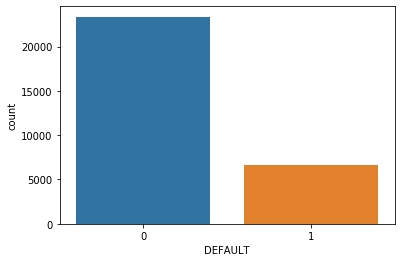

In [9]:
print(df['DEFAULT'].value_counts())
sns.countplot(df['DEFAULT'])
plt.show()

Here we can see that the data is highly imbalanced.
- The number of defaulters are 6636 which is only 

# EDA

Here since we have all the data in Integers, we dont need to change the data type

# Univariate Analysis

## Value Counts - Balance

2    18112
1    11888
Name: SEX, dtype: int64


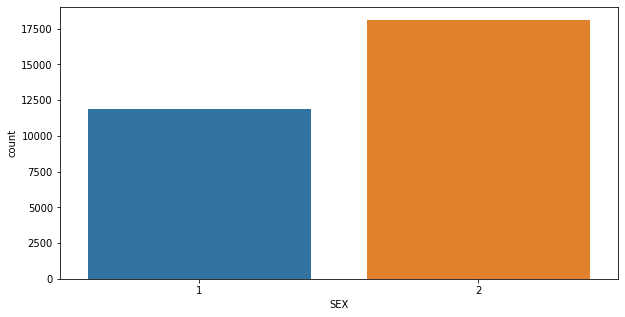

2    14030
1    10585
3     4917
5      280
4      123
6       51
0       14
Name: EDUCATION, dtype: int64


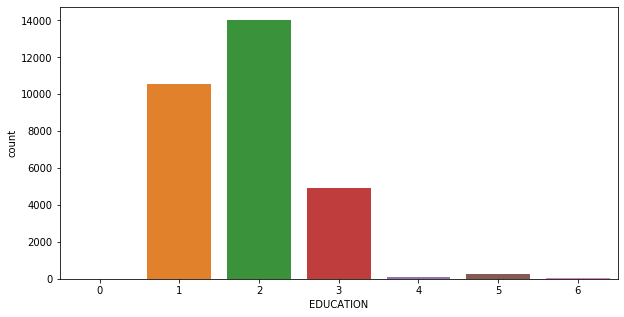

2    15964
1    13659
3      323
0       54
Name: MARRIAGE, dtype: int64


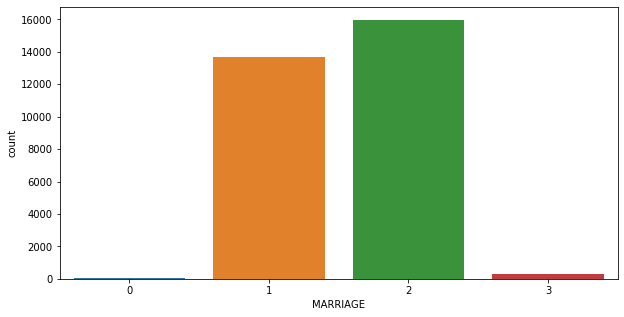

 0    14737
-1     5686
 1     3688
-2     2759
 2     2667
 3      322
 4       76
 5       26
 8       19
 6       11
 7        9
Name: PAY_1, dtype: int64


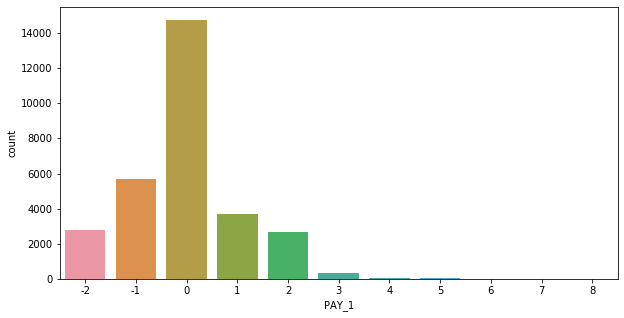

 0    15730
-1     6050
 2     3927
-2     3782
 3      326
 4       99
 1       28
 5       25
 7       20
 6       12
 8        1
Name: PAY_2, dtype: int64


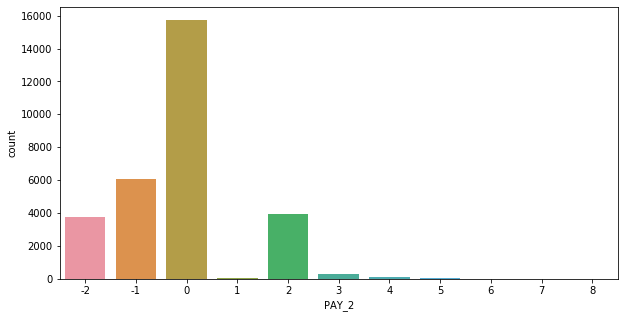

 0    15764
-1     5938
-2     4085
 2     3819
 3      240
 4       76
 7       27
 6       23
 5       21
 1        4
 8        3
Name: PAY_3, dtype: int64


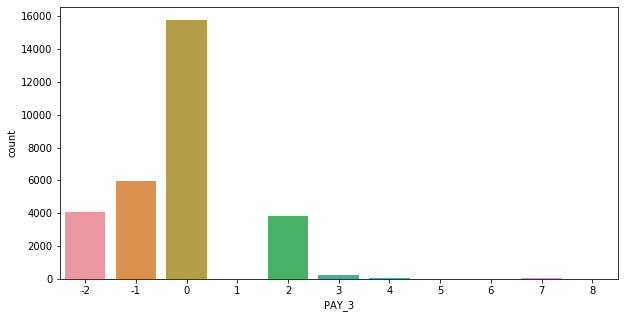

 0    16455
-1     5687
-2     4348
 2     3159
 3      180
 4       69
 7       58
 5       35
 6        5
 8        2
 1        2
Name: PAY_4, dtype: int64


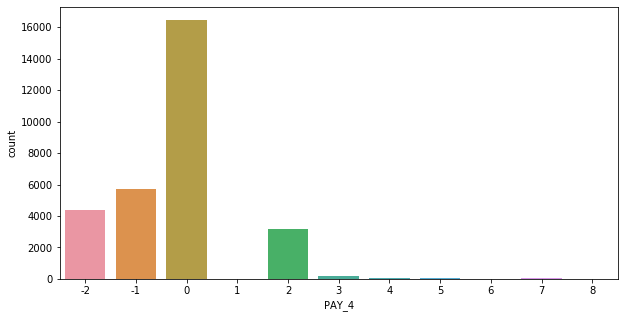

 0    16947
-1     5539
-2     4546
 2     2626
 3      178
 4       84
 7       58
 5       17
 6        4
 8        1
Name: PAY_5, dtype: int64


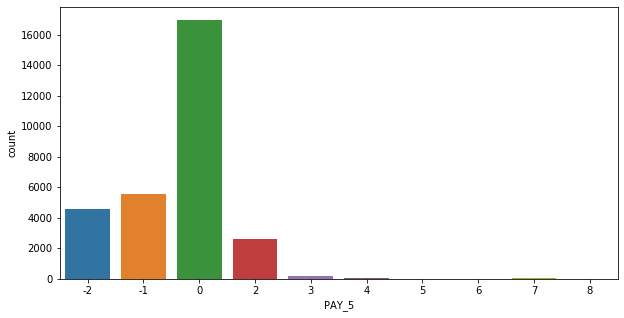

 0    16286
-1     5740
-2     4895
 2     2766
 3      184
 4       49
 7       46
 6       19
 5       13
 8        2
Name: PAY_6, dtype: int64


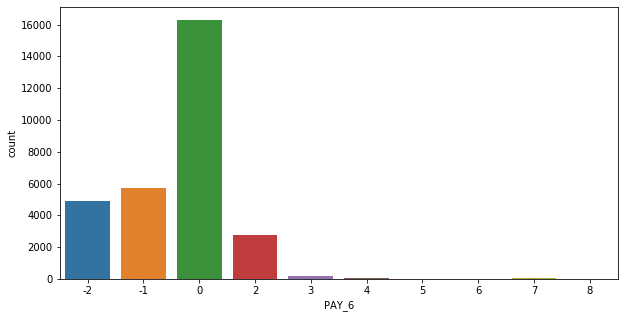

In [10]:
for i in [ 'SEX', 'EDUCATION', 'MARRIAGE', 'PAY_1',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']:
    print(df[i].value_counts())
    plt.figure(figsize=(10,5))
    sns.countplot(df[i])
    plt.show()

## BOX PLOT - Outliers

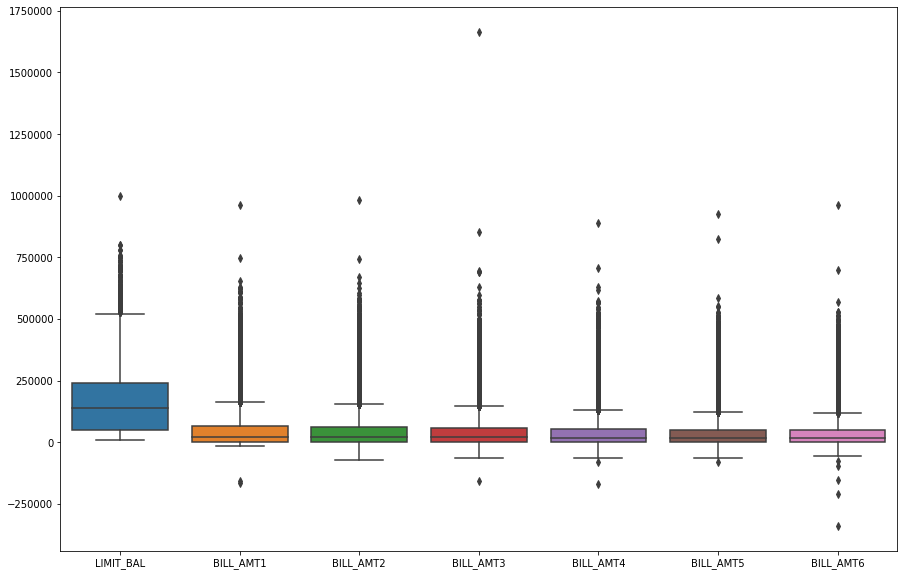

In [11]:
plt.figure(figsize=(15,10))
sns.boxplot(data=df[['LIMIT_BAL','BILL_AMT1', 'BILL_AMT2','BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']])
plt.show()

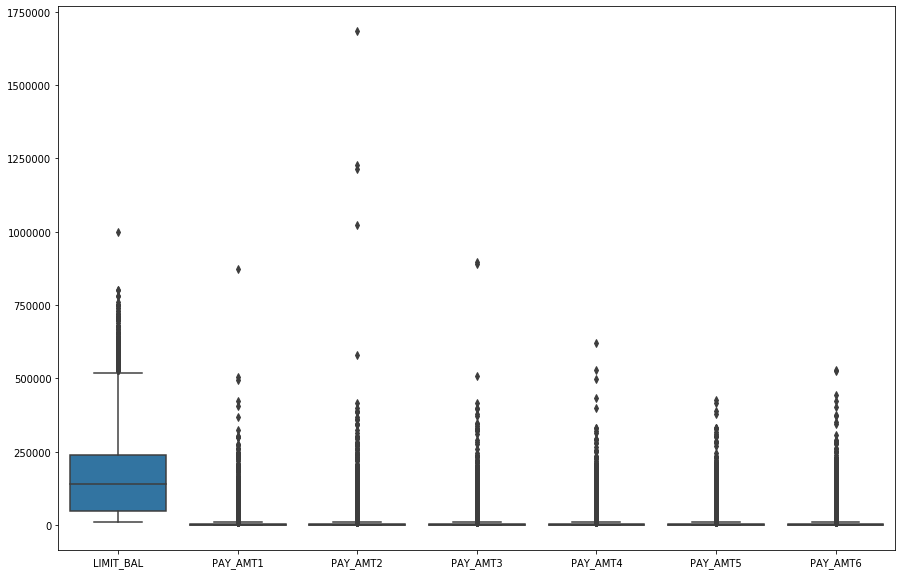

In [12]:
plt.figure(figsize=(15,10))
sns.boxplot(data=df[['LIMIT_BAL','PAY_AMT1','PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']])
plt.show()

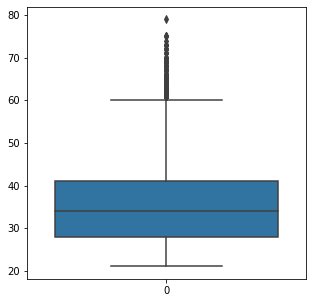

In [13]:
plt.figure(figsize=(5,5))
sns.boxplot(data=df['AGE'])
plt.show()

## Outliers

In [14]:
num_var = df.select_dtypes(exclude='object')
for i in num_var:
    
    q1 = df[i].quantile(0.25)
    q3 = df[i].quantile(0.75)

    IQR = q3 - q1
    UL = q3 + 1.5*IQR
    LL = q1 - 1.5*IQR

    print('IQR of',i,'= ',IQR)
    print('UL of',i,'= ',UL)
    print('LL of',i,'= ',LL)
    print('Number of Outliers in',i,' = ',(df.shape[0] - df[(df[i]<UL) & (df[i]>LL)].shape[0]))
    print(' ')

IQR of ID =  14999.5
UL of ID =  44999.5
LL of ID =  -14998.5
Number of Outliers in ID  =  0
 
IQR of LIMIT_BAL =  190000.0
UL of LIMIT_BAL =  525000.0
LL of LIMIT_BAL =  -235000.0
Number of Outliers in LIMIT_BAL  =  167
 
IQR of SEX =  1.0
UL of SEX =  3.5
LL of SEX =  -0.5
Number of Outliers in SEX  =  0
 
IQR of EDUCATION =  1.0
UL of EDUCATION =  3.5
LL of EDUCATION =  -0.5
Number of Outliers in EDUCATION  =  454
 
IQR of MARRIAGE =  1.0
UL of MARRIAGE =  3.5
LL of MARRIAGE =  -0.5
Number of Outliers in MARRIAGE  =  0
 
IQR of AGE =  13.0
UL of AGE =  60.5
LL of AGE =  8.5
Number of Outliers in AGE  =  272
 
IQR of PAY_1 =  1.0
UL of PAY_1 =  1.5
LL of PAY_1 =  -2.5
Number of Outliers in PAY_1  =  3130
 
IQR of PAY_2 =  1.0
UL of PAY_2 =  1.5
LL of PAY_2 =  -2.5
Number of Outliers in PAY_2  =  4410
 
IQR of PAY_3 =  1.0
UL of PAY_3 =  1.5
LL of PAY_3 =  -2.5
Number of Outliers in PAY_3  =  4209
 
IQR of PAY_4 =  1.0
UL of PAY_4 =  1.5
LL of PAY_4 =  -2.5
Number of Outliers in PAY_4

## Distribution Plot

In [15]:
mi0 = df[df['DEFAULT']==0]
mi1 = df[df['DEFAULT']==1]

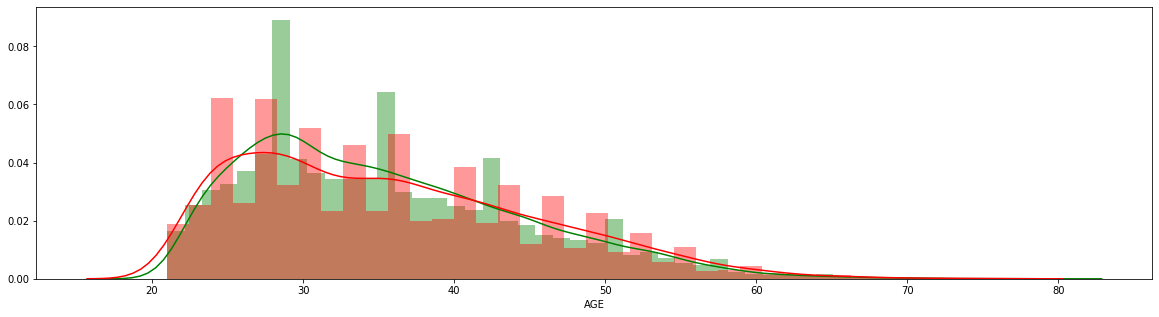

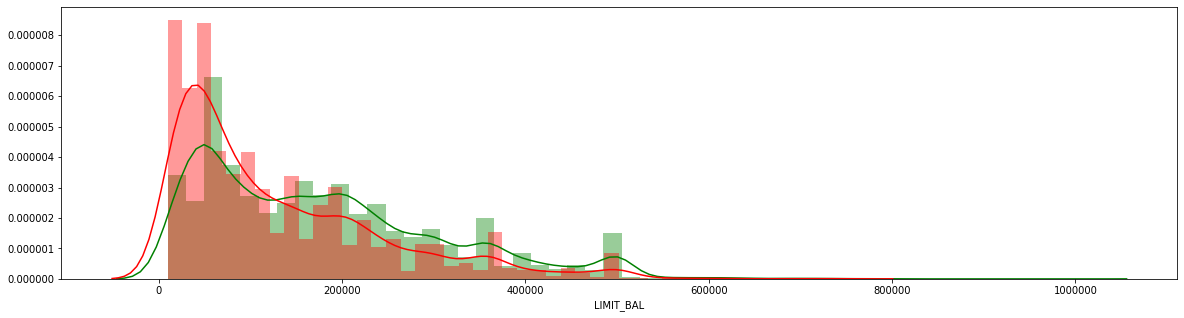

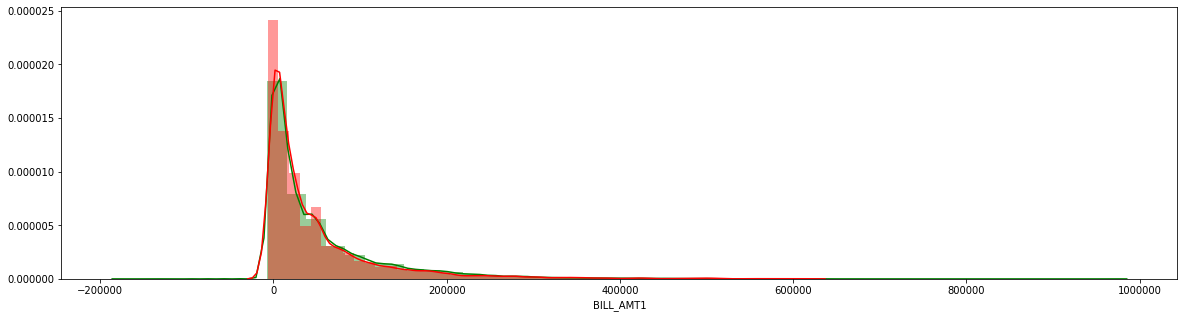

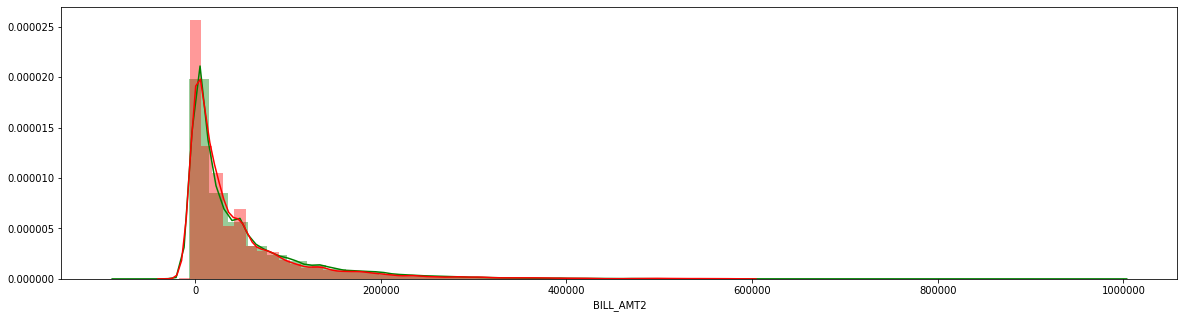

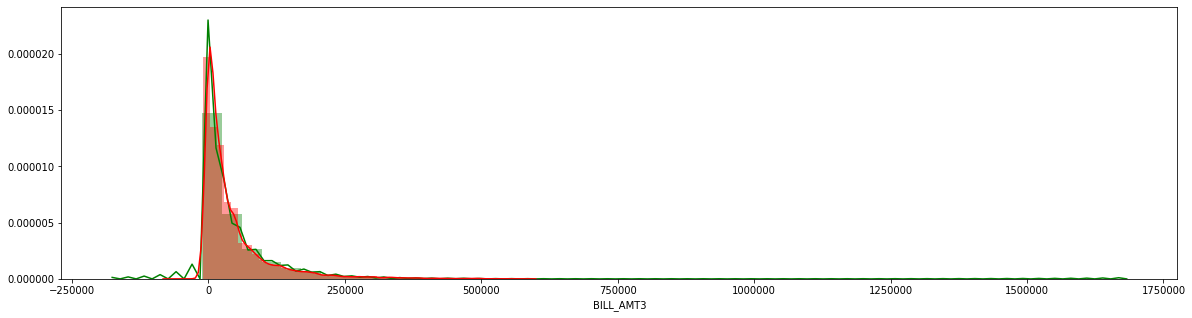

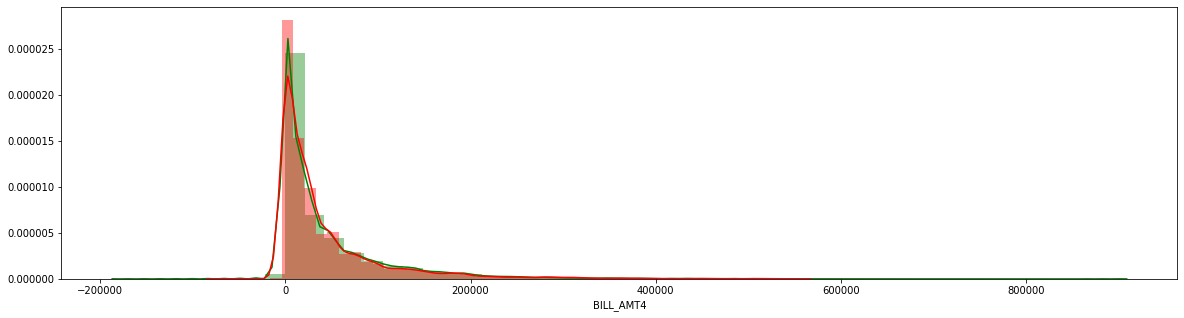

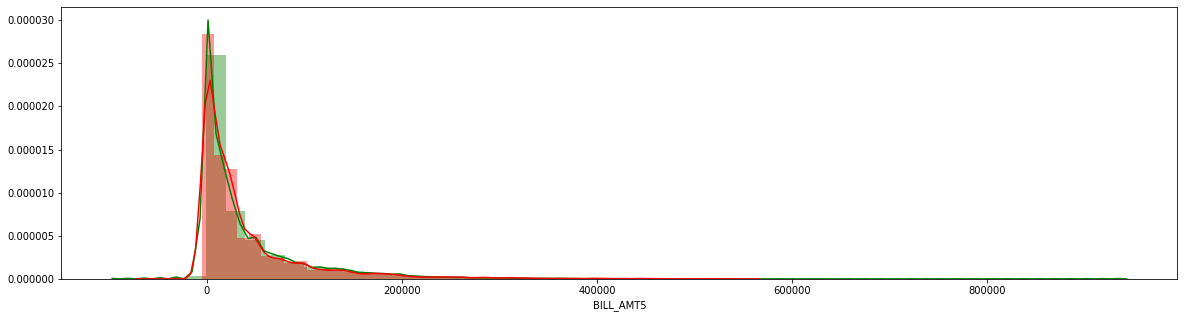

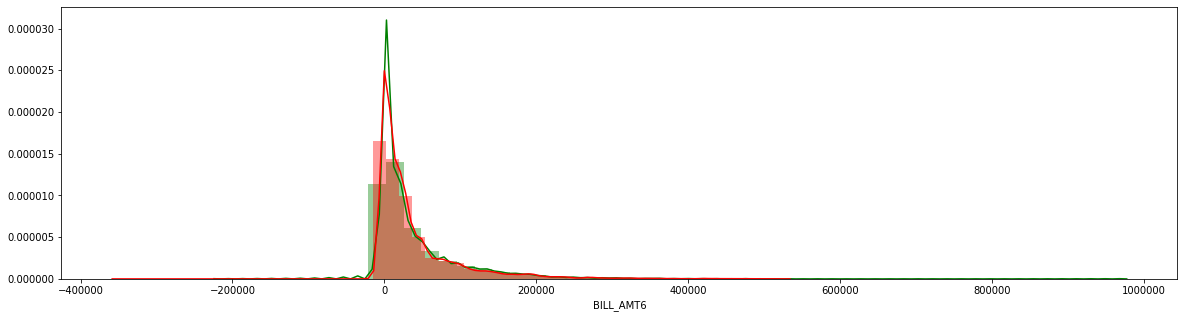

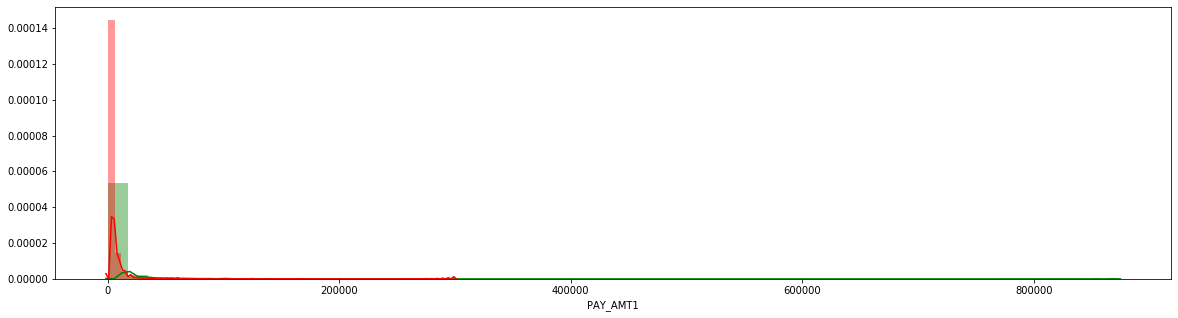

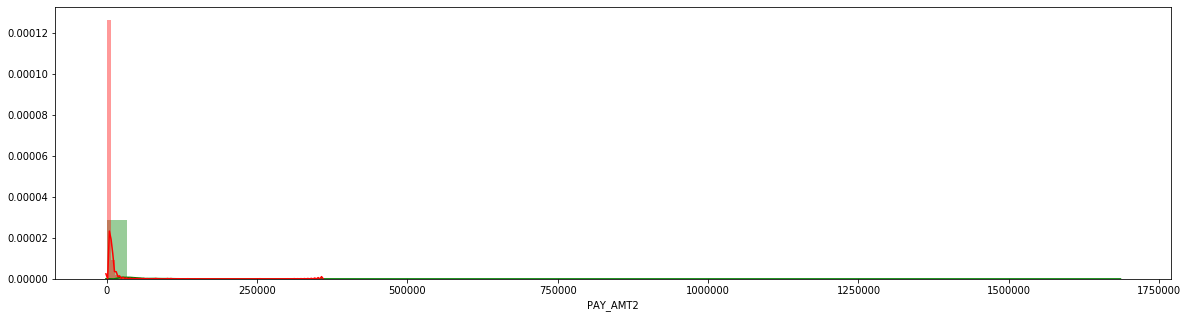

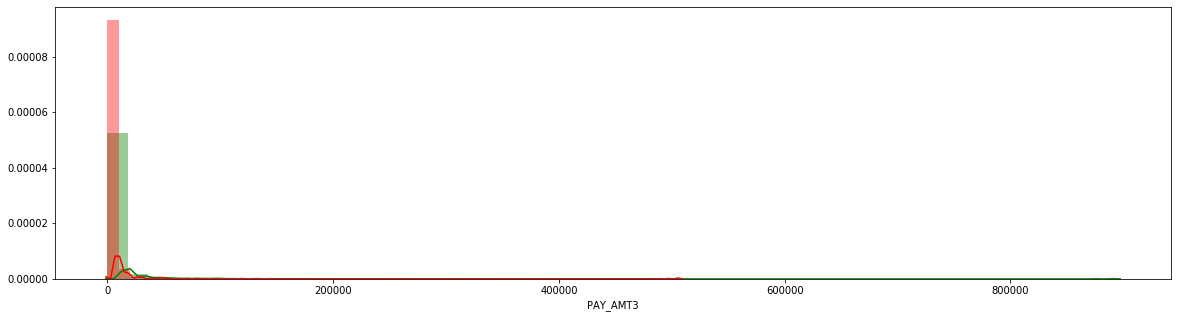

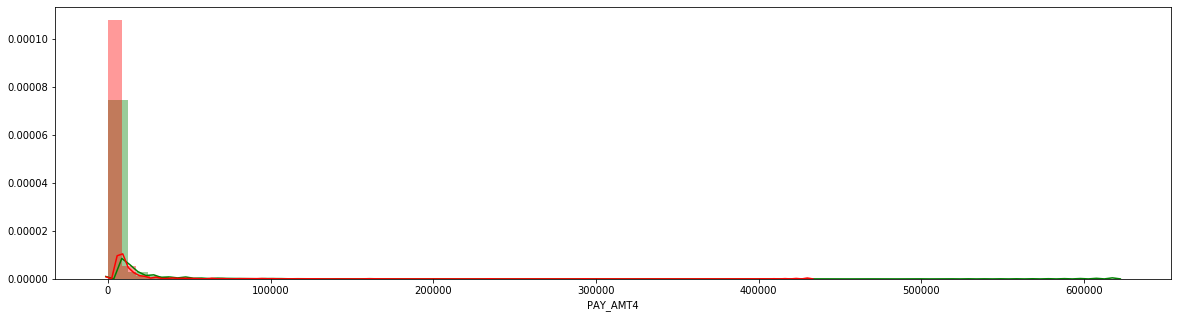

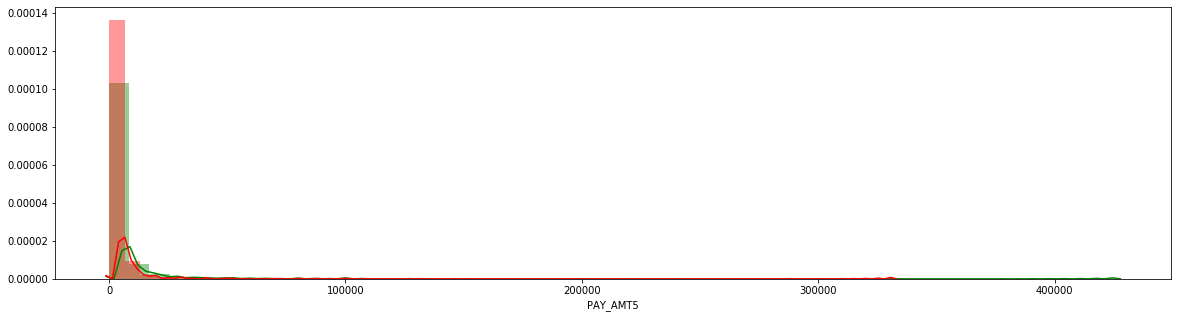

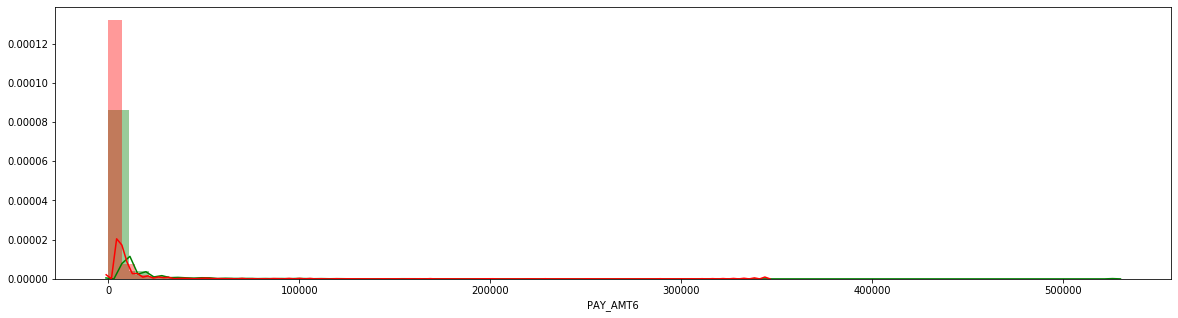

In [16]:
for i in con_col:
    plt.figure(figsize=(20,5))
    sns.distplot(mi0[i],color='g')
    sns.distplot(mi1[i],color='r')
    plt.show()

# Pair Plot

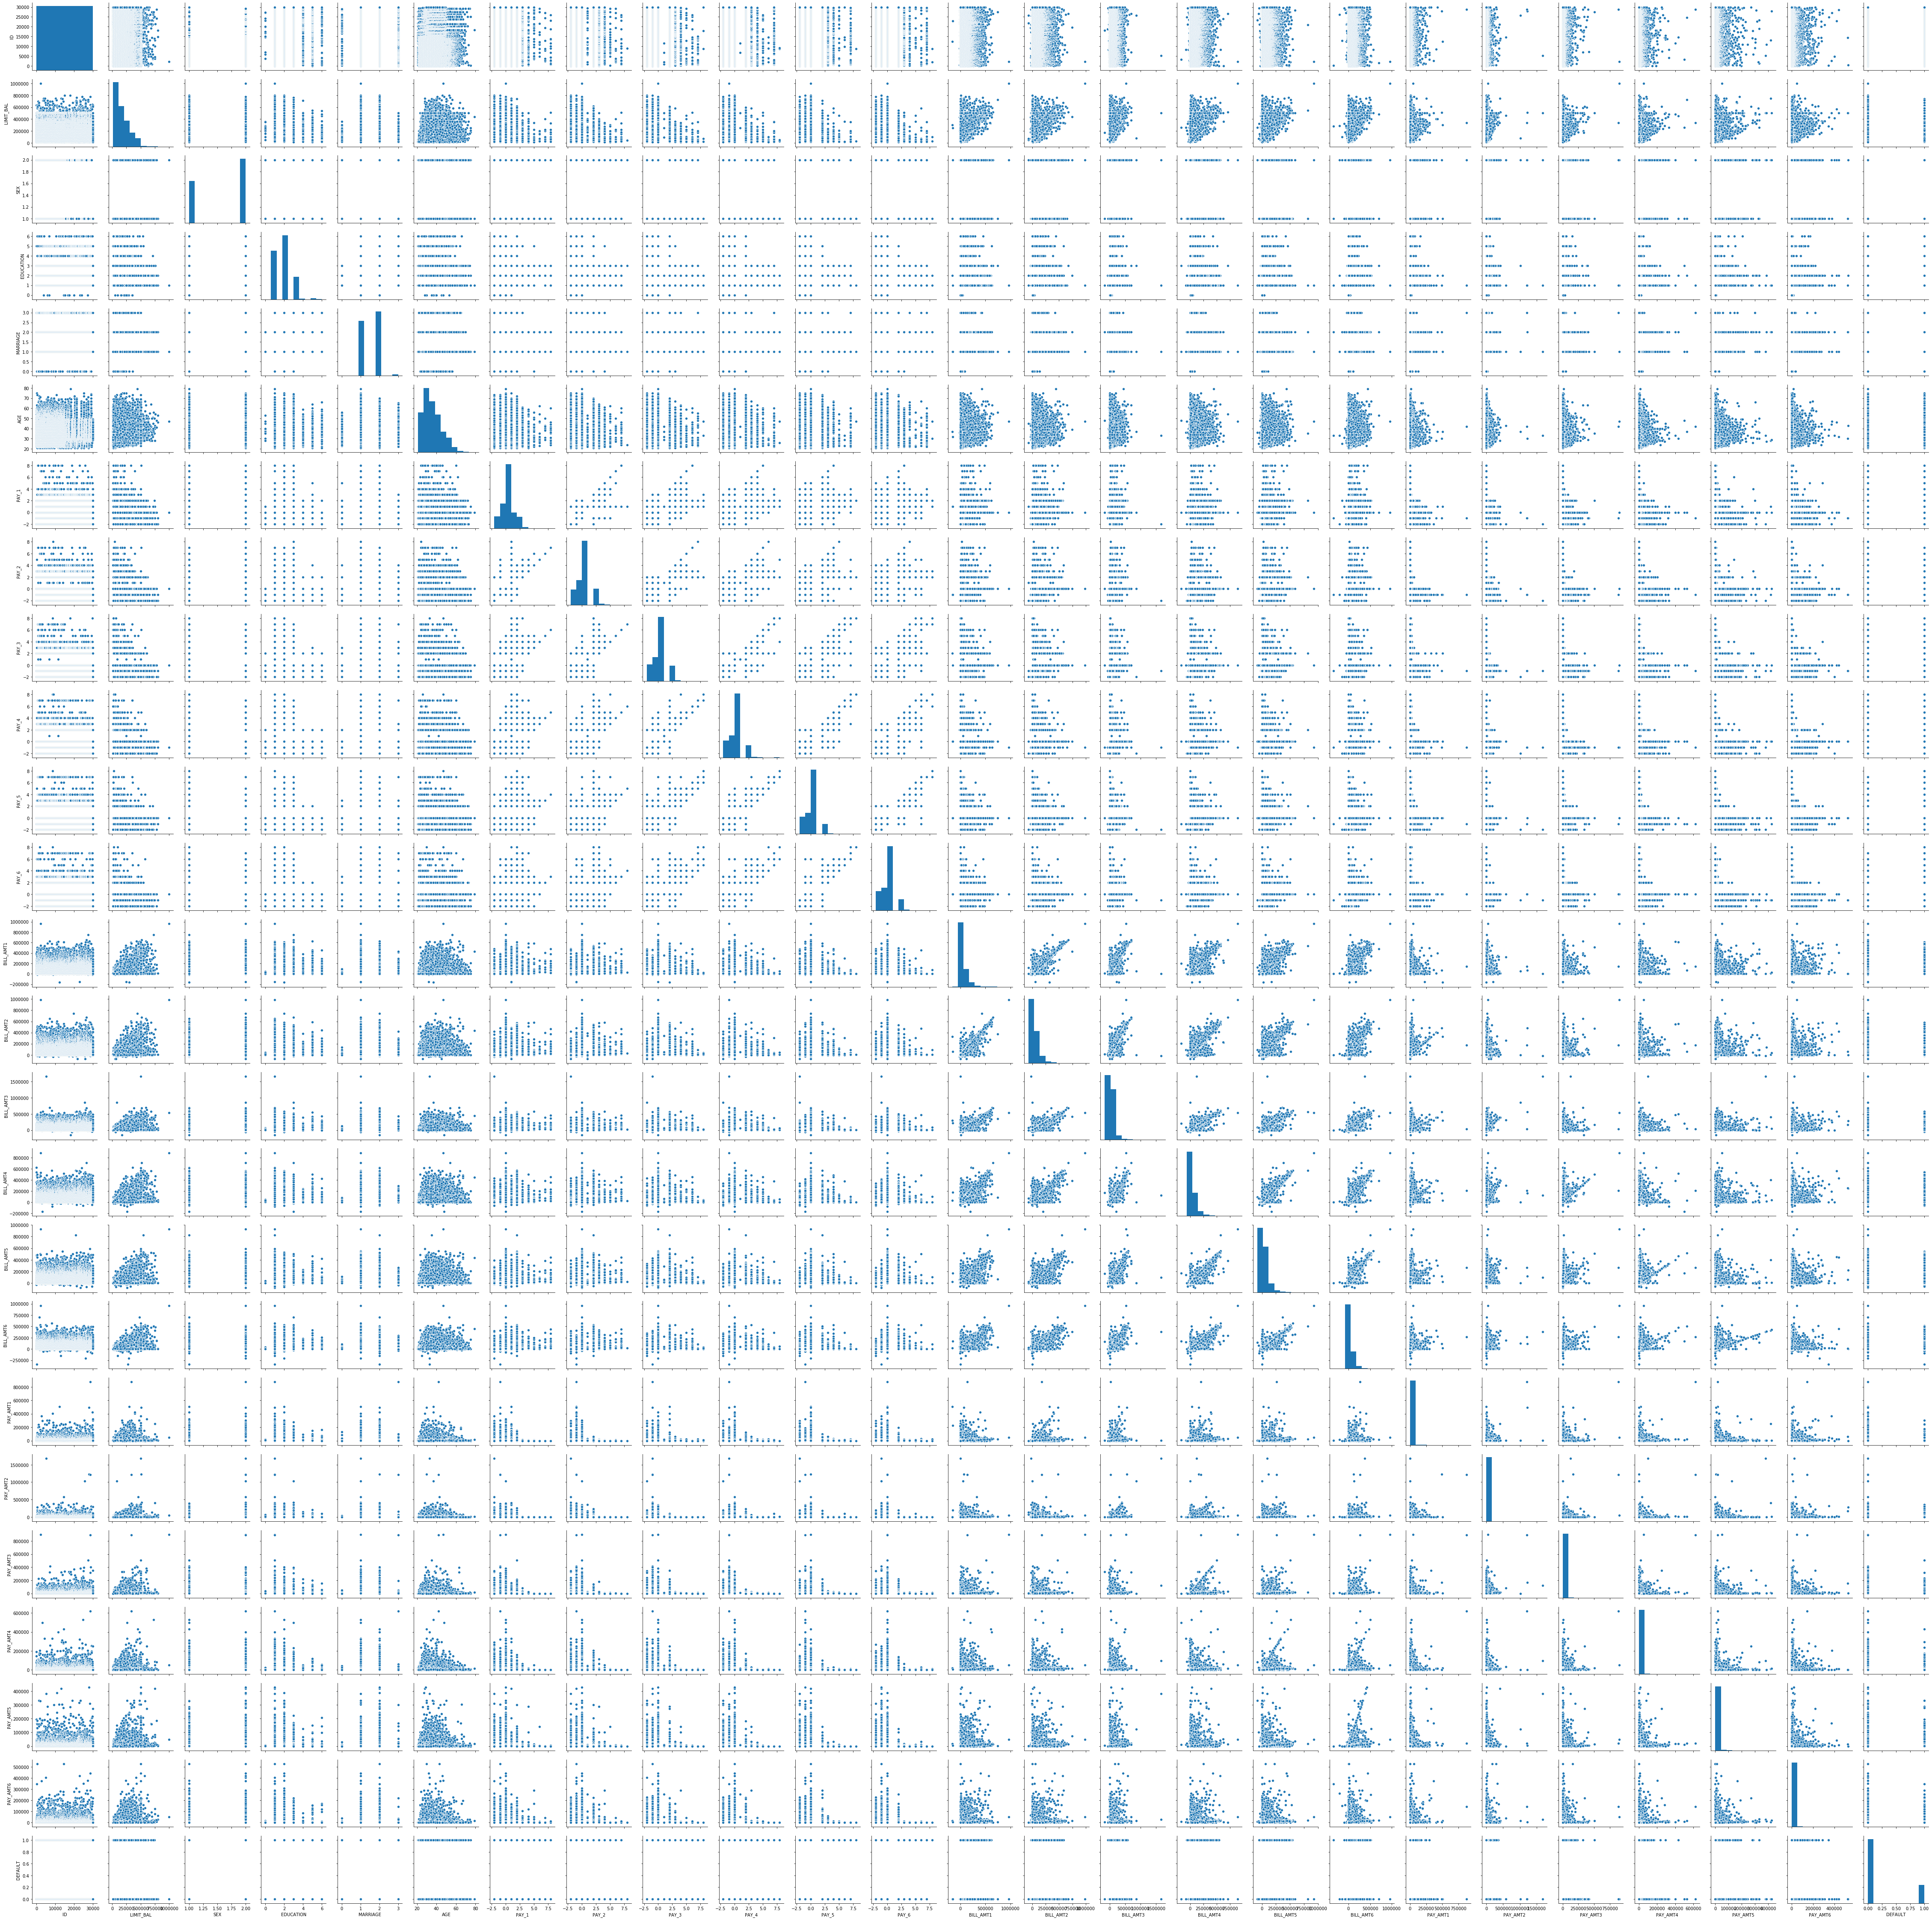

In [17]:
sns.pairplot(df)
plt.show()

# Correlation- Heat Map

In [18]:
corr=df.corr()
corr

ID  LIMIT_BAL       SEX  EDUCATION  MARRIAGE       AGE  \
ID         1.000000   0.026179  0.018497   0.039177 -0.029079  0.018678   
LIMIT_BAL  0.026179   1.000000  0.024755  -0.219161 -0.108139  0.144713   
SEX        0.018497   0.024755  1.000000   0.014232 -0.031389 -0.090874   
EDUCATION  0.039177  -0.219161  0.014232   1.000000 -0.143464  0.175061   
MARRIAGE  -0.029079  -0.108139 -0.031389  -0.143464  1.000000 -0.414170   
AGE        0.018678   0.144713 -0.090874   0.175061 -0.414170  1.000000   
PAY_1     -0.030575  -0.271214 -0.057643   0.105364  0.019917 -0.039447   
PAY_2     -0.011215  -0.296382 -0.070771   0.121566  0.024199 -0.050148   
PAY_3     -0.018494  -0.286123 -0.066096   0.114025  0.032688 -0.053048   
PAY_4     -0.002735  -0.267460 -0.060173   0.108793  0.033122 -0.049722   
PAY_5     -0.022199  -0.249411 -0.055064   0.097520  0.035629 -0.053826   
PAY_6     -0.020270  -0.235195 -0.044008   0.082316  0.034345 -0.048773   
BILL_AMT1  0.019389   0.285430 -0.033642   0.023581 -0.023472  0.056239   
BILL_AMT2  0.017982   0.278314 -0.031183   0.018749 -0.021602  0.054283   
BILL_AMT3  0.024354   0.283236 -0.024563   0.013002 -0.024909  0.053710   
BILL_AMT4  0.040351   0.293988 -0.021880  -0.000451 -0.023344  0.051353   
BILL_AMT5  0.016705   0.295562 -0.017005  -0.007567 -0.025393  0.049345   
BILL_AMT6  0.016730   0.290389 -0.016733  -0.009099 -0.021207  0.047613   
PAY_AMT1   0.009742   0.195236 -0.000242  -0.037456 -0.005979  0.026147   
PAY_AMT2   0.008406   0.178408 -0.001391  -0.030038 -0.008093  0.021785   
PAY_AMT3   0.039151   0.210167 -0.008597  -0.039943 -0.003541  0.029247   
PAY_AMT4   0.007793   0.203242 -0.002229  -0.038218 -0.012659  0.021379   
PAY_AMT5   0.000652   0.217202 -0.001667  -0.040358 -0.001205  0.022850   
PAY_AMT6   0.003000   0.219595 -0.002766  -0.037200 -0.006641  0.019478   
DEFAULT   -0.013952  -0.153520 -0.039961   0.028006 -0.024339  0.013890   

              PAY_1     PAY_2     PAY_3     PAY_4  ...  BILL_AMT4  BILL_AMT5  \
ID        -0.030575 -0.011215 -0.018494 -0.002735  ...   0.040351   0.016705   
LIMIT_BAL -0.271214 -0.296382 -0.286123 -0.267460  ...   0.293988   0.295562   
SEX       -0.057643 -0.070771 -0.066096 -0.060173  ...  -0.021880  -0.017005   
EDUCATION  0.105364  0.121566  0.114025  0.108793  ...  -0.000451  -0.007567   
MARRIAGE   0.019917  0.024199  0.032688  0.033122  ...  -0.023344  -0.025393   
AGE       -0.039447 -0.050148 -0.053048 -0.049722  ...   0.051353   0.049345   
PAY_1      1.000000  0.672164  0.574245  0.538841  ...   0.179125   0.180635   
PAY_2      0.672164  1.000000  0.766552  0.662067  ...   0.222237   0.221348   
PAY_3      0.574245  0.766552  1.000000  0.777359  ...   0.227202   0.225145   
PAY_4      0.538841  0.662067  0.777359  1.000000  ...   0.245917   0.242902   
PAY_5      0.509426  0.622780  0.686775  0.819835  ...   0.271915   0.269783   
PAY_6      0.474553  0.575501  0.632684  0.716449  ...   0.266356   0.290894   
BILL_AMT1  0.187068  0.234887  0.208473  0.202812  ...   0.860272   0.829779   
BILL_AMT2  0.189859  0.235257  0.237295  0.225816  ...   0.892482   0.859778   
BILL_AMT3  0.179785  0.224146  0.227494  0.244983  ...   0.923969   0.883910   
BILL_AMT4  0.179125  0.222237  0.227202  0.245917  ...   1.000000   0.940134   
BILL_AMT5  0.180635  0.221348  0.225145  0.242902  ...   0.940134   1.000000   
BILL_AMT6  0.176980  0.219403  0.222327  0.239154  ...   0.900941   0.946197   
PAY_AMT1  -0.079269 -0.080701  0.001295 -0.009362  ...   0.233012   0.217031   
PAY_AMT2  -0.070101 -0.058990 -0.066793 -0.001944  ...   0.207564   0.181246   
PAY_AMT3  -0.070561 -0.055901 -0.053311 -0.069235  ...   0.300023   0.252305   
PAY_AMT4  -0.064005 -0.046858 -0.046067 -0.043461  ...   0.130191   0.293118   
PAY_AMT5  -0.058190 -0.037093 -0.035863 -0.033590  ...   0.160433   0.141574   
PAY_AMT6  -0.058673 -0.036500 -0.035861 -0.026565  ...   0.177637   0.164184   
DEFAULT    0.324794  0.263551  0.235253  0.216614  ...  -0.010156 

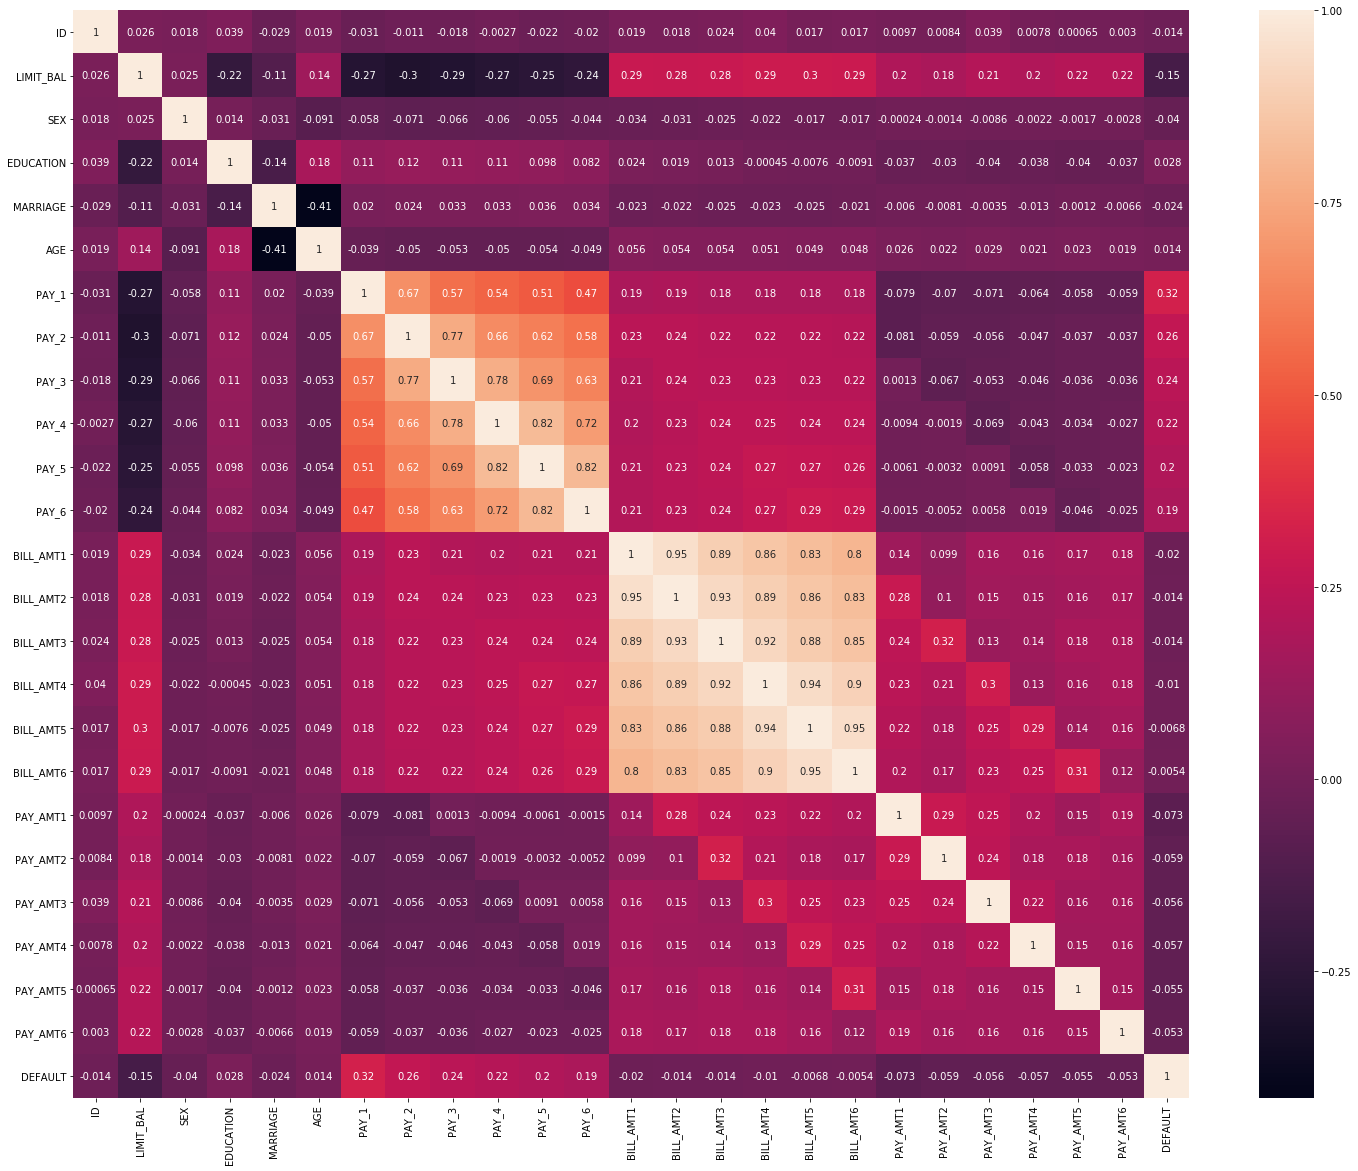

In [19]:
plt.figure(figsize=(25,20))
sns.heatmap(corr,annot=True)
plt.show()

### Base Model using LogisticRegression:

In [20]:
X =df.drop('DEFAULT',axis=1)
y = df['DEFAULT']

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

logreg = LogisticRegression(solver='liblinear', fit_intercept=True)
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [22]:
X =df.drop('DEFAULT',axis=1)
y = df['DEFAULT']
Xc=sm.add_constant(X)

logreg= LogisticRegression(solver='liblinear',fit_intercept=True)
model= logreg.fit(X_train,y_train)

y_prob_train=logreg.predict_proba(X_train)[:,1]
y_pred_train= logreg.predict(X_train)

y_prob_test=logreg.predict_proba(X_test)[:,1]
y_pred_test= logreg.predict(X_test)

print('Confusion Matrix - Train:','\n',confusion_matrix(y_train,y_pred_train))
print('Overall Accuracy - Train:',accuracy_score(y_train,y_pred_train))

print('\n','Confusion Matrix - Test:','\n',confusion_matrix(y_test,y_pred_test))
print('Overall Accuracy - Test:',accuracy_score(y_test,y_pred_test))

Confusion Matrix - Train: 
 [[16363     1]
 [ 4635     1]]
Overall Accuracy - Train: 0.7792380952380953

 Confusion Matrix - Test: 
 [[7000    0]
 [2000    0]]
Overall Accuracy - Test: 0.7777777777777778


In [23]:
#Classification for test
print(classification_report(y_test,y_pred_test))

              precision    recall  f1-score   support

           0       0.78      1.00      0.88      7000
           1       0.00      0.00      0.00      2000

    accuracy                           0.78      9000
   macro avg       0.39      0.50      0.44      9000
weighted avg       0.60      0.78      0.68      9000



In [24]:
#classification for train
print(classification_report(y_train,y_pred_train))

              precision    recall  f1-score   support

           0       0.78      1.00      0.88     16364
           1       0.50      0.00      0.00      4636

    accuracy                           0.78     21000
   macro avg       0.64      0.50      0.44     21000
weighted avg       0.72      0.78      0.68     21000



AUC of train:  0.6401036920203422


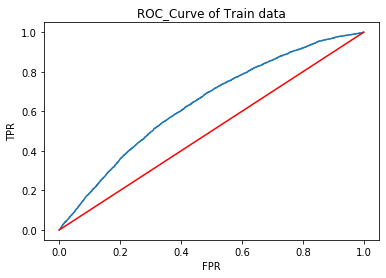

In [25]:
from sklearn.metrics import roc_auc_score, roc_curve

print('AUC of train: ', roc_auc_score(y_train, y_prob_train)) #for train data

fpr, tpr, thresholds = roc_curve(y_train, y_prob_train)

plt.plot(fpr, tpr)
plt.plot(fpr, fpr, 'r-')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC_Curve of Train data')
plt.show()

AUC of test:  0.6505089285714286


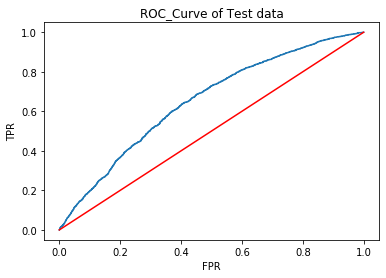

In [26]:
print('AUC of test: ', roc_auc_score(y_test, y_prob_test)) #for test data

fpr, tpr, thresholds = roc_curve(y_test, y_prob_test)

plt.plot(fpr, tpr)
plt.plot(fpr, fpr, 'r-')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC_Curve of Test data')
plt.show()

In [27]:
print(thresholds) #first one is more than 1
thresholds[thresholds>1]=1 #made value more than 1 to 1
thresholds

[1.48947018e+00 4.89470183e-01 4.87552235e-01 ... 1.67989707e-04
 1.53151980e-04 7.85247008e-16]


array([1.00000000e+00, 4.89470183e-01, 4.87552235e-01, ...,
       1.67989707e-04, 1.53151980e-04, 7.85247008e-16])

AUC of train:  0.6401036920203422


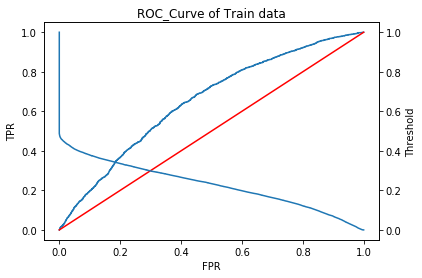

In [28]:
print('AUC of train: ', roc_auc_score(y_train, y_prob_train)) #for train data

fig, ax = plt.subplots()

ax.plot(fpr, tpr) #blue color
ax.plot(fpr, fpr, 'r-') #red color
plt.xlabel('FPR')
plt.ylabel('TPR')
ax1 = ax.twinx()
ax1.plot(fpr,thresholds) 
ax1.set_ylabel('Threshold')

plt.title('ROC_Curve of Train data')
plt.show()

AUC of test:  0.6505089285714286


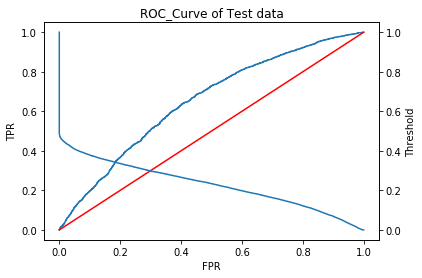

In [29]:
print('AUC of test: ', roc_auc_score(y_test, y_prob_test)) #for train data

fig, ax = plt.subplots()

ax.plot(fpr, tpr) #blue color
ax.plot(fpr, fpr, 'r-') #red color
plt.xlabel('FPR')
plt.ylabel('TPR')
ax1 = ax.twinx()
ax1.plot(fpr,thresholds) 
ax1.set_ylabel('Threshold')

plt.title('ROC_Curve of Test data')
plt.show()

### Random Forest Classifier:

In [30]:
rfc = RandomForestClassifier(n_estimators=10,random_state=1)

rfc.fit(X_train,y_train)

y_pred_train = rfc.predict(X_train)
y_prob_train = rfc.predict_proba(X_train)[:,1]

y_pred_test = rfc.predict(X_test)
y_prob_test = rfc.predict_proba(X_test)[:,1]

from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve

print('Accuracy of Random Forest_train: ', accuracy_score(y_pred_train, y_train))
print('Accuracy of Random Forest_test: ', accuracy_score(y_pred_test, y_test))

print('AUC of Random Forest_train: ', roc_auc_score(y_train, y_prob_train))
print('AUC of Random Forest_test: ', roc_auc_score(y_test, y_prob_test))

Accuracy of Random Forest_train:  0.9817619047619047
Accuracy of Random Forest_test:  0.805
AUC of Random Forest_train:  0.9993014361688328
AUC of Random Forest_test:  0.7379866071428571


In [31]:
#Classification for test
print(classification_report(y_test,y_pred_test))

              precision    recall  f1-score   support

           0       0.83      0.94      0.88      7000
           1       0.62      0.32      0.42      2000

    accuracy                           0.81      9000
   macro avg       0.72      0.63      0.65      9000
weighted avg       0.78      0.81      0.78      9000



In [32]:
#classification for train
print(classification_report(y_train,y_pred_train))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     16364
           1       1.00      0.92      0.96      4636

    accuracy                           0.98     21000
   macro avg       0.99      0.96      0.97     21000
weighted avg       0.98      0.98      0.98     21000



### Hyperparameter Tuning:

In [33]:
rfc = RandomForestClassifier(random_state=1)

params = {'n_estimators': sp_randint(5,30),
          'criterion' : ['gini','entropy'],
          'max_depth' : sp_randint(2,10),
          'min_samples_split' : sp_randint(2,20),
          'min_samples_leaf' : sp_randint(1,20),
          'max_features' : sp_randint(2,18)}

rand_search_rfc = RandomizedSearchCV(rfc, param_distributions=params, random_state=1, cv=3)

rand_search_rfc.fit(X,y)

rand_search_rfc.best_params_

{'criterion': 'gini',
 'max_depth': 2,
 'max_features': 15,
 'min_samples_leaf': 16,
 'min_samples_split': 12,
 'n_estimators': 13}

In [34]:
rfc = RandomForestClassifier(**rand_search_rfc.best_params_)

rfc.fit(X_train,y_train)

y_pred_train = rfc.predict(X_train)
y_prob_train = rfc.predict_proba(X_train)[:,1]

y_pred_test = rfc.predict(X_test)
y_prob_test = rfc.predict_proba(X_test)[:,1]

from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve

print('Confusion Matrix - Train:','\n',confusion_matrix(y_train,y_pred_train))
print('Overall Accuracy - Train:',accuracy_score(y_train,y_pred_train))

print('\n','Confusion Matrix - Test:','\n',confusion_matrix(y_test,y_pred_test))
print('Overall Accuracy - Test:',accuracy_score(y_test,y_pred_test))

Confusion Matrix - Train: 
 [[15685   679]
 [ 3093  1543]]
Overall Accuracy - Train: 0.8203809523809524

 Confusion Matrix - Test: 
 [[6728  272]
 [1369  631]]
Overall Accuracy - Test: 0.8176666666666667


In [35]:
#Classification for test
print(classification_report(y_test,y_pred_test))

              precision    recall  f1-score   support

           0       0.83      0.96      0.89      7000
           1       0.70      0.32      0.43      2000

    accuracy                           0.82      9000
   macro avg       0.76      0.64      0.66      9000
weighted avg       0.80      0.82      0.79      9000



In [36]:
#classification for train
print(classification_report(y_train,y_pred_train))

              precision    recall  f1-score   support

           0       0.84      0.96      0.89     16364
           1       0.69      0.33      0.45      4636

    accuracy                           0.82     21000
   macro avg       0.76      0.65      0.67     21000
weighted avg       0.80      0.82      0.79     21000



AUC of train:  0.7482565595704622


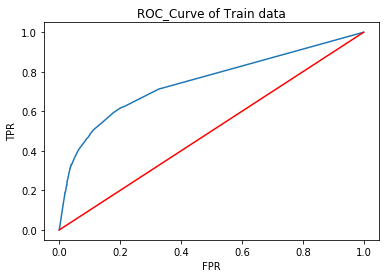

In [37]:
from sklearn.metrics import roc_auc_score, roc_curve

print('AUC of train: ', roc_auc_score(y_train, y_prob_train)) #for train data

fpr, tpr, thresholds = roc_curve(y_train, y_prob_train)

plt.plot(fpr, tpr)
plt.plot(fpr, fpr, 'r-')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC_Curve of Train data')
plt.show()

AUC of test:  0.7412327142857142


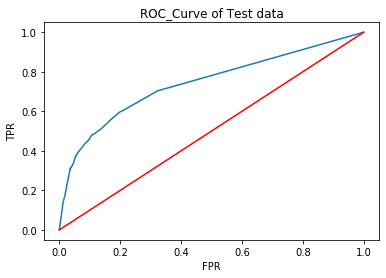

In [38]:
print('AUC of test: ', roc_auc_score(y_test, y_prob_test)) #for test data

fpr, tpr, thresholds = roc_curve(y_test, y_prob_test)

plt.plot(fpr, tpr)
plt.plot(fpr, fpr, 'r-')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC_Curve of Test data')
plt.show()

In [39]:
print(thresholds) #first one is more than 1
thresholds[thresholds>1]=1 #made value more than 1 to 1
thresholds

[1.70929814 0.70929814 0.703368   0.69207264 0.69138713 0.68545699
 0.66823148 0.66727745 0.66626394 0.66528734 0.66330329 0.64936644
 0.64835293 0.64402435 0.64343629 0.6391936  0.63809421 0.62818328
 0.62128259 0.6201832  0.61329902 0.6007871  0.60001355 0.58949174
 0.58356159 0.58287609 0.57261737 0.56565058 0.55539186 0.55470636
 0.54548093 0.53748085 0.53059667 0.52991117 0.51268566 0.41394725
 0.40213443 0.4008192  0.39877297 0.38900639 0.38696015 0.38564492
 0.37683958 0.36502677 0.36371154 0.3616653  0.35189872 0.34985248
 0.34853725 0.33672444 0.23318901 0.22430003 0.21404493 0.21248721
 0.20912575 0.20515595 0.19731293 0.1954284  0.19334313 0.18998167
 0.18875009 0.18719237 0.17816885 0.17693727 0.17537955 0.17201808
 0.16804829 0.16020526 0.15623547 0.152874   0.14106118]


array([1.        , 0.70929814, 0.703368  , 0.69207264, 0.69138713,
       0.68545699, 0.66823148, 0.66727745, 0.66626394, 0.66528734,
       0.66330329, 0.64936644, 0.64835293, 0.64402435, 0.64343629,
       0.6391936 , 0.63809421, 0.62818328, 0.62128259, 0.6201832 ,
       0.61329902, 0.6007871 , 0.60001355, 0.58949174, 0.58356159,
       0.58287609, 0.57261737, 0.56565058, 0.55539186, 0.55470636,
       0.54548093, 0.53748085, 0.53059667, 0.52991117, 0.51268566,
       0.41394725, 0.40213443, 0.4008192 , 0.39877297, 0.38900639,
       0.38696015, 0.38564492, 0.37683958, 0.36502677, 0.36371154,
       0.3616653 , 0.35189872, 0.34985248, 0.34853725, 0.33672444,
       0.23318901, 0.22430003, 0.21404493, 0.21248721, 0.20912575,
       0.20515595, 0.19731293, 0.1954284 , 0.19334313, 0.18998167,
       0.18875009, 0.18719237, 0.17816885, 0.17693727, 0.17537955,
       0.17201808, 0.16804829, 0.16020526, 0.15623547, 0.152874  ,
       0.14106118])

AUC of train:  0.7482565595704622


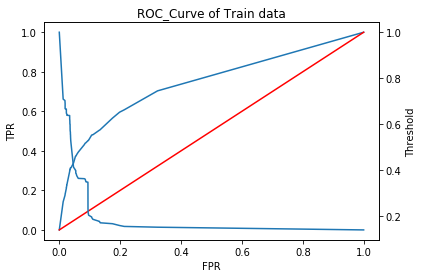

In [40]:
print('AUC of train: ', roc_auc_score(y_train, y_prob_train)) #for train data

fig, ax = plt.subplots()

ax.plot(fpr, tpr) #blue color
ax.plot(fpr, fpr, 'r-') #red color
plt.xlabel('FPR')
plt.ylabel('TPR')
ax1 = ax.twinx()
ax1.plot(fpr,thresholds) 
ax1.set_ylabel('Threshold')

plt.title('ROC_Curve of Train data')
plt.show()

AUC of test:  0.7412327142857142


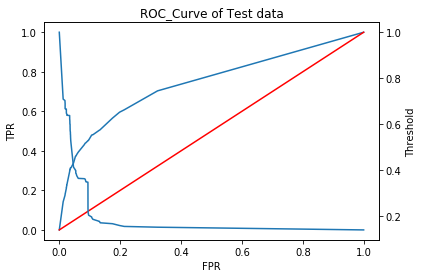

In [41]:
print('AUC of test: ', roc_auc_score(y_test, y_prob_test)) #for train data

fig, ax = plt.subplots()

ax.plot(fpr, tpr) #blue color
ax.plot(fpr, fpr, 'r-') #red color
plt.xlabel('FPR')
plt.ylabel('TPR')
ax1 = ax.twinx()
ax1.plot(fpr,thresholds) 
ax1.set_ylabel('Threshold')

plt.title('ROC_Curve of Test data')
plt.show()

### LGBM:

In [42]:
import lightgbm as lgb
lgbc = lgb.LGBMClassifier()

In [43]:
lgbc.fit(X_train, y_train)

y_pred_test = lgbc.predict(X_test)
y_prob_test = lgbc.predict_proba(X_test)[:,1]

y_pred_train = lgbc.predict(X_train)
y_prob_train = lgbc.predict_proba(X_train)[:,1]

In [44]:
print('Accuracy on Train Set: ', accuracy_score(y_train, y_pred_train))
print('Accuracy on Test Set: ', accuracy_score(y_test, y_pred_test))
print('AUC of Train Set: ', roc_auc_score(y_train, y_prob_train))
print('AUC of Test Set: ', roc_auc_score(y_test, y_prob_test))

Accuracy on Train Set:  0.851
Accuracy on Test Set:  0.8186666666666667
AUC of Train Set:  0.8868165448830311
AUC of Test Set:  0.7777822857142858


In [45]:
#Classification for test
print(classification_report(y_test,y_pred_test))
print(classification_report(y_train,y_pred_train))

              precision    recall  f1-score   support

           0       0.84      0.95      0.89      7000
           1       0.67      0.35      0.47      2000

    accuracy                           0.82      9000
   macro avg       0.76      0.65      0.68      9000
weighted avg       0.80      0.82      0.80      9000

              precision    recall  f1-score   support

           0       0.86      0.97      0.91     16364
           1       0.79      0.44      0.57      4636

    accuracy                           0.85     21000
   macro avg       0.82      0.70      0.74     21000
weighted avg       0.84      0.85      0.83     21000



### LGBM with Tuning

In [46]:
from sklearn.model_selection import RandomizedSearchCV

from scipy.stats import randint as sp_randint

lgbc = lgb.LGBMClassifier(random_state=1)

params = {'n_estimators': sp_randint(5,100),
          'max_depth' : sp_randint(2,20),
          'min_child_samples' : sp_randint(1,20),
          'num_leaves' : sp_randint(5,20)}

rand_search_lgbc = RandomizedSearchCV(lgbc, param_distributions=params, random_state=1, cv=3)

rand_search_lgbc.fit(X_train, y_train)

rand_search_lgbc.best_params_

{'max_depth': 18, 'min_child_samples': 2, 'n_estimators': 81, 'num_leaves': 12}

In [47]:
lgbc = lgb.LGBMClassifier(**rand_search_lgbc.best_params_, random_state=1)

lgbc.fit(X_train,y_train)

y_pred_test = lgbc.predict(X_test)
y_prob_test = lgbc.predict_proba(X_test)[:,1]

y_pred_train = lgbc.predict(X_train)
y_prob_train = lgbc.predict_proba(X_train)[:,1]

print('Accuracy on Train Set: ', accuracy_score(y_train, y_pred_train))
print('Accuracy on Test Set: ', accuracy_score(y_test, y_pred_test))
print('AUC of Train Set: ', roc_auc_score(y_train, y_prob_train))
print('AUC of Test Set: ', roc_auc_score(y_test, y_prob_test))

Accuracy on Train Set:  0.8296666666666667
Accuracy on Test Set:  0.8197777777777778
AUC of Train Set:  0.8265705733813719
AUC of Test Set:  0.7821413928571429


In [48]:
#Classification for test
print(classification_report(y_test,y_pred_test))
print(classification_report(y_train,y_pred_train))

              precision    recall  f1-score   support

           0       0.84      0.95      0.89      7000
           1       0.68      0.36      0.47      2000

    accuracy                           0.82      9000
   macro avg       0.76      0.65      0.68      9000
weighted avg       0.80      0.82      0.80      9000

              precision    recall  f1-score   support

           0       0.85      0.96      0.90     16364
           1       0.71      0.39      0.50      4636

    accuracy                           0.83     21000
   macro avg       0.78      0.67      0.70     21000
weighted avg       0.82      0.83      0.81     21000



AUC of train:  0.8265705733813719


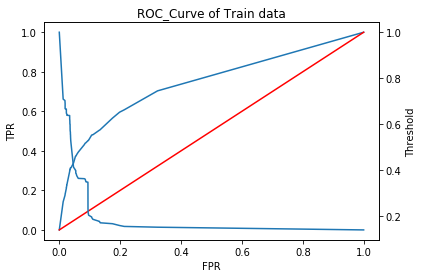

In [49]:
print('AUC of train: ', roc_auc_score(y_train, y_prob_train)) #for train data

fig, ax = plt.subplots()

ax.plot(fpr, tpr) #blue color
ax.plot(fpr, fpr, 'r-') #red color
plt.xlabel('FPR')
plt.ylabel('TPR')
ax1 = ax.twinx()
ax1.plot(fpr,thresholds) 
ax1.set_ylabel('Threshold')

plt.title('ROC_Curve of Train data')
plt.show()

AUC of test:  0.7821413928571429


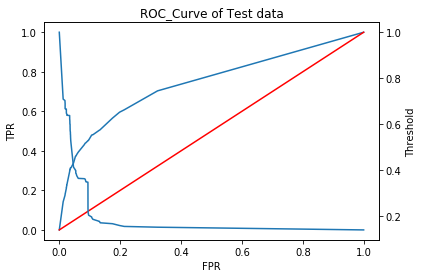

In [50]:
print('AUC of test: ', roc_auc_score(y_test, y_prob_test)) #for train data

fig, ax = plt.subplots()

ax.plot(fpr, tpr) #blue color
ax.plot(fpr, fpr, 'r-') #red color
plt.xlabel('FPR')
plt.ylabel('TPR')
ax1 = ax.twinx()
ax1.plot(fpr,thresholds) 
ax1.set_ylabel('Threshold')

plt.title('ROC_Curve of Test data')
plt.show()

### Naive Bayes:

In [51]:
from sklearn.naive_bayes import BernoulliNB
bnb = BernoulliNB()

bnb.fit(X_train, y_train)

y_pred_train = bnb.predict(X_train)
y_prob_train = bnb.predict_proba(X_train)[:,1]

y_pred_test = bnb.predict(X_test)
y_prob_test = bnb.predict_proba(X_test)[:,1]

from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve

print('Accuracy of Bayes_train: ', accuracy_score(y_pred_train, y_train))
print('Accuracy of Bayes_test: ', accuracy_score(y_pred_test, y_test))

print('AUC of Bayes_train: ', roc_auc_score(y_train, y_prob_train))
print('AUC of Bayes_test: ', roc_auc_score(y_test, y_prob_test))

Accuracy of Bayes_train:  0.770095238095238
Accuracy of Bayes_test:  0.771
AUC of Bayes_train:  0.7366726759681441
AUC of Bayes_test:  0.7342563214285713


In [52]:
#Classification for test
print(classification_report(y_test,y_pred_test))

#classification for train
print(classification_report(y_train,y_pred_train))

              precision    recall  f1-score   support

           0       0.85      0.85      0.85      7000
           1       0.48      0.48      0.48      2000

    accuracy                           0.77      9000
   macro avg       0.67      0.67      0.67      9000
weighted avg       0.77      0.77      0.77      9000

              precision    recall  f1-score   support

           0       0.86      0.85      0.85     16364
           1       0.48      0.50      0.49      4636

    accuracy                           0.77     21000
   macro avg       0.67      0.67      0.67     21000
weighted avg       0.77      0.77      0.77     21000



# KNN:

In [53]:

knn=KNeighborsClassifier()
knn.fit(X_train,y_train)

y_pred_train = knn.predict(X_train)
y_prob_train = knn.predict_proba(X_train)[:,1]

y_pred_test = knn.predict(X_test)
y_prob_test = knn.predict_proba(X_test)[:,1]

from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve

print('Accuracy of Bayes_train: ', accuracy_score(y_pred_train, y_train))
print('Accuracy of Bayes_test: ', accuracy_score(y_pred_test, y_test))

print('AUC of Bayes_train: ', roc_auc_score(y_train, y_prob_train))
print('AUC of Bayes_test: ', roc_auc_score(y_test, y_prob_test))

Accuracy of Bayes_train:  0.8144285714285714
Accuracy of Bayes_test:  0.75
AUC of Bayes_train:  0.8292686362074707
AUC of Bayes_test:  0.5934543214285715


In [54]:
#Classification for test
print(classification_report(y_test,y_pred_test))

#classification for train
print(classification_report(y_train,y_pred_train))

              precision    recall  f1-score   support

           0       0.79      0.91      0.85      7000
           1       0.37      0.17      0.24      2000

    accuracy                           0.75      9000
   macro avg       0.58      0.54      0.54      9000
weighted avg       0.70      0.75      0.71      9000

              precision    recall  f1-score   support

           0       0.83      0.95      0.89     16364
           1       0.66      0.34      0.44      4636

    accuracy                           0.81     21000
   macro avg       0.75      0.64      0.67     21000
weighted avg       0.80      0.81      0.79     21000



#### Tunning:

In [55]:
knn=KNeighborsClassifier()

params ={'n_neighbors':sp_randint(5,30),
         'p':sp_randint(1,5)}

rand_search_knn=RandomizedSearchCV(knn,param_distributions=params,cv=3,random_state=1)

rand_search_knn.fit(X,y)
rand_search_knn.best_params_

{'n_neighbors': 23, 'p': 1}

In [56]:
knn=KNeighborsClassifier(**rand_search_knn.best_params_)

knn.fit(X_train,y_train)

y_pred_train = knn.predict(X_train)
y_prob_train = knn.predict_proba(X_train)[:,1]

y_pred_test = knn.predict(X_test)
y_prob_test = knn.predict_proba(X_test)[:,1]

from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve

print('Accuracy of Bayes_train: ', accuracy_score(y_pred_train, y_train))
print('Accuracy of Bayes_test: ', accuracy_score(y_pred_test, y_test))

print('AUC of Bayes_train: ', roc_auc_score(y_train, y_prob_train))
print('AUC of Bayes_test: ', roc_auc_score(y_test, y_prob_test))

Accuracy of Bayes_train:  0.7863809523809524
Accuracy of Bayes_test:  0.7806666666666666
AUC of Bayes_train:  0.7295936923767719
AUC of Bayes_test:  0.6491554642857144


In [57]:
#Classification for test
print(classification_report(y_test,y_pred_test))

#classification for train
print(classification_report(y_train,y_pred_train))

              precision    recall  f1-score   support

           0       0.79      0.98      0.87      7000
           1       0.54      0.09      0.16      2000

    accuracy                           0.78      9000
   macro avg       0.66      0.53      0.52      9000
weighted avg       0.73      0.78      0.71      9000

              precision    recall  f1-score   support

           0       0.79      0.98      0.88     16364
           1       0.59      0.10      0.18      4636

    accuracy                           0.79     21000
   macro avg       0.69      0.54      0.53     21000
weighted avg       0.75      0.79      0.72     21000



### Adaboost

In [58]:
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier


# using adaboost
ada = AdaBoostClassifier(n_estimators=100)
ada.fit(X_train,y_train)
y_pred = ada.predict(X_test)
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))
y_pred_train = ada.predict(X_train)
print(classification_report(y_train,y_pred_train))

0.8153333333333334
              precision    recall  f1-score   support

           0       0.83      0.96      0.89      7000
           1       0.68      0.32      0.43      2000

    accuracy                           0.82      9000
   macro avg       0.76      0.64      0.66      9000
weighted avg       0.80      0.82      0.79      9000

              precision    recall  f1-score   support

           0       0.84      0.96      0.89     16364
           1       0.69      0.34      0.45      4636

    accuracy                           0.82     21000
   macro avg       0.76      0.65      0.67     21000
weighted avg       0.80      0.82      0.80     21000



### GradientBoost

In [59]:
# using Gradientboost
grad = GradientBoostingClassifier()
grad.fit(X_train,y_train)
y_pred = grad.predict(X_test)
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))
y_pred_train = grad.predict(X_train)
print(classification_report(y_train,y_pred_train))

0.8182222222222222
              precision    recall  f1-score   support

           0       0.84      0.95      0.89      7000
           1       0.67      0.35      0.46      2000

    accuracy                           0.82      9000
   macro avg       0.76      0.65      0.68      9000
weighted avg       0.80      0.82      0.80      9000

[[6660  340]
 [1296  704]]
              precision    recall  f1-score   support

           0       0.85      0.95      0.90     16364
           1       0.70      0.38      0.50      4636

    accuracy                           0.83     21000
   macro avg       0.77      0.67      0.70     21000
weighted avg       0.81      0.83      0.81     21000



## SMOTE:

In [60]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()
X_train_sm, y_train_sm = smote.fit_sample(X_train, y_train)


### Base Model using LogisticRegression:

In [61]:
logreg = LogisticRegression(solver='liblinear', fit_intercept=True)
logreg.fit(X_train_sm, y_train_sm)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [62]:
y_prob_train=logreg.predict_proba(X_train_sm)[:,1]
y_pred_train= logreg.predict(X_train_sm)

y_prob_test=logreg.predict_proba(X_test)[:,1]
y_pred_test= logreg.predict(X_test)

print('Confusion Matrix - Train:','\n',confusion_matrix(y_train_sm,y_pred_train))
print('Overall Accuracy - Train:',accuracy_score(y_train_sm,y_pred_train))

print('\n','Confusion Matrix - Test:','\n',confusion_matrix(y_test,y_pred_test))
print('Overall Accuracy - Test:',accuracy_score(y_test,y_pred_test))

Confusion Matrix - Train: 
 [[10527  5837]
 [ 5277 11087]]
Overall Accuracy - Train: 0.6604131019310682

 Confusion Matrix - Test: 
 [[4523 2477]
 [ 717 1283]]
Overall Accuracy - Test: 0.6451111111111111


In [63]:
#Classification for test
print(classification_report(y_test,y_pred_test))

              precision    recall  f1-score   support

           0       0.86      0.65      0.74      7000
           1       0.34      0.64      0.45      2000

    accuracy                           0.65      9000
   macro avg       0.60      0.64      0.59      9000
weighted avg       0.75      0.65      0.67      9000



In [64]:
#classification for train
print(classification_report(y_train_sm,y_pred_train))

              precision    recall  f1-score   support

           0       0.67      0.64      0.65     16364
           1       0.66      0.68      0.67     16364

    accuracy                           0.66     32728
   macro avg       0.66      0.66      0.66     32728
weighted avg       0.66      0.66      0.66     32728



AUC of train:  0.7274199536922211


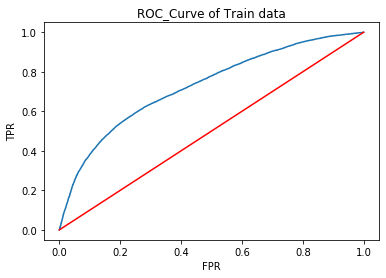

In [65]:
from sklearn.metrics import roc_auc_score, roc_curve

print('AUC of train: ', roc_auc_score(y_train_sm, y_prob_train)) #for train data

fpr, tpr, thresholds = roc_curve(y_train_sm, y_prob_train)

plt.plot(fpr, tpr)
plt.plot(fpr, fpr, 'r-')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC_Curve of Train data')
plt.show()

AUC of test:  0.7087696428571428


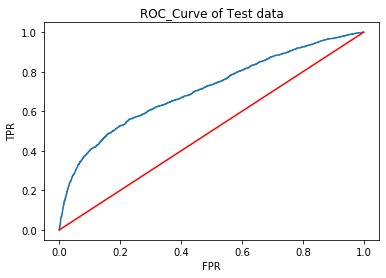

In [66]:
print('AUC of test: ', roc_auc_score(y_test, y_prob_test)) #for test data

fpr, tpr, thresholds = roc_curve(y_test, y_prob_test)

plt.plot(fpr, tpr)
plt.plot(fpr, fpr, 'r-')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC_Curve of Test data')
plt.show()

In [67]:
print(thresholds) #first one is more than 1
thresholds[thresholds>1]=1 #made value more than 1 to 1
thresholds

[1.96971323e+00 9.69713228e-01 9.10563882e-01 ... 6.82457304e-03
 4.66788476e-03 2.84578462e-13]


array([1.00000000e+00, 9.69713228e-01, 9.10563882e-01, ...,
       6.82457304e-03, 4.66788476e-03, 2.84578462e-13])

AUC of train:  0.7274199536922211


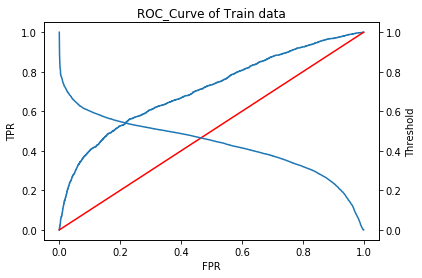

In [68]:
print('AUC of train: ', roc_auc_score(y_train_sm, y_prob_train)) #for train data

fig, ax = plt.subplots()

ax.plot(fpr, tpr) #blue color
ax.plot(fpr, fpr, 'r-') #red color
plt.xlabel('FPR')
plt.ylabel('TPR')
ax1 = ax.twinx()
ax1.plot(fpr,thresholds) 
ax1.set_ylabel('Threshold')

plt.title('ROC_Curve of Train data')
plt.show()

AUC of test:  0.7087696428571428


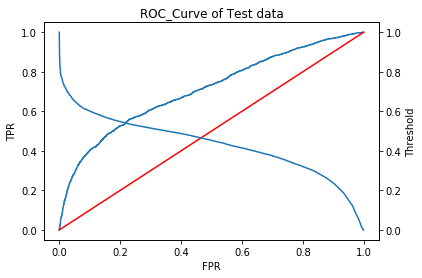

In [69]:
print('AUC of test: ', roc_auc_score(y_test, y_prob_test)) #for train data

fig, ax = plt.subplots()

ax.plot(fpr, tpr) #blue color
ax.plot(fpr, fpr, 'r-') #red color
plt.xlabel('FPR')
plt.ylabel('TPR')
ax1 = ax.twinx()
ax1.plot(fpr,thresholds) 
ax1.set_ylabel('Threshold')

plt.title('ROC_Curve of Test data')
plt.show()

### Random Forest Classifier:

In [70]:
rfc = RandomForestClassifier(n_estimators=10,random_state=1)

rfc.fit(X_train_sm, y_train_sm)

y_pred_train = rfc.predict(X_train_sm)
y_prob_train = rfc.predict_proba(X_train_sm)[:,1]

y_pred_test = rfc.predict(X_test)
y_prob_test = rfc.predict_proba(X_test)[:,1]

from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve

print('Accuracy of Random Forest_train: ', accuracy_score(y_pred_train, y_train_sm))
print('Accuracy of Random Forest_test: ', accuracy_score(y_pred_test, y_test))

print('AUC of Random Forest_train: ', roc_auc_score(y_train_sm, y_prob_train))
print('AUC of Random Forest_test: ', roc_auc_score(y_test, y_prob_test))

Accuracy of Random Forest_train:  0.9918418479589343
Accuracy of Random Forest_test:  0.7723333333333333
AUC of Random Forest_train:  0.9997578053630911
AUC of Random Forest_test:  0.7213521785714285


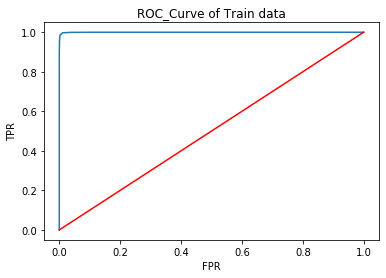

In [71]:
fpr, tpr, thresholds = roc_curve(y_train_sm, y_prob_train)

plt.plot(fpr, tpr)
plt.plot(fpr, fpr, 'r-')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC_Curve of Train data')
plt.show()


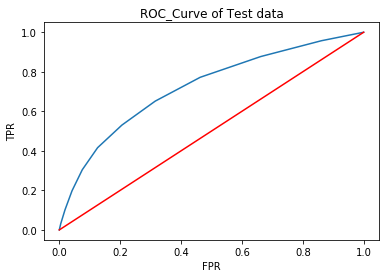

In [72]:

fpr, tpr, thresholds = roc_curve(y_test, y_prob_test)

plt.plot(fpr, tpr)
plt.plot(fpr, fpr, 'r-')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC_Curve of Test data')
plt.show()

In [73]:
#Classification for test
print(classification_report(y_test,y_pred_test))

              precision    recall  f1-score   support

           0       0.84      0.87      0.86      7000
           1       0.49      0.42      0.45      2000

    accuracy                           0.77      9000
   macro avg       0.66      0.65      0.65      9000
weighted avg       0.76      0.77      0.77      9000



In [74]:
#classification for train
print(classification_report(y_train_sm,y_pred_train))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     16364
           1       1.00      0.99      0.99     16364

    accuracy                           0.99     32728
   macro avg       0.99      0.99      0.99     32728
weighted avg       0.99      0.99      0.99     32728



### Hyperparameter Tuning:

In [75]:
rfc = RandomForestClassifier(random_state=1)

params = {'n_estimators': sp_randint(5,30),
          'criterion' : ['gini','entropy'],
          'max_depth' : sp_randint(2,10),
          'min_samples_split' : sp_randint(2,20),
          'min_samples_leaf' : sp_randint(1,20),
          'max_features' : sp_randint(2,18)}

rand_search_rfc = RandomizedSearchCV(rfc, param_distributions=params, random_state=1, cv=3)

rand_search_rfc.fit(X,y)

rand_search_rfc.best_params_

{'criterion': 'gini',
 'max_depth': 2,
 'max_features': 15,
 'min_samples_leaf': 16,
 'min_samples_split': 12,
 'n_estimators': 13}

Accuracy of Random Forest_train:  0.6919457345392325
Accuracy of Random Forest_test:  0.7716666666666666
AUC of Random Forest_train:  0.7743993292924516
AUC of Random Forest_test:  0.7439813928571428
              precision    recall  f1-score   support

           0       0.87      0.84      0.85      7000
           1       0.49      0.54      0.51      2000

    accuracy                           0.77      9000
   macro avg       0.68      0.69      0.68      9000
weighted avg       0.78      0.77      0.78      9000

              precision    recall  f1-score   support

           0       0.65      0.83      0.73     16364
           1       0.77      0.55      0.64     16364

    accuracy                           0.69     32728
   macro avg       0.71      0.69      0.69     32728
weighted avg       0.71      0.69      0.69     32728

AUC of train:  0.7743993292924516


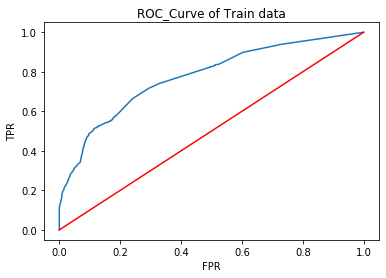

AUC of test:  0.7439813928571428


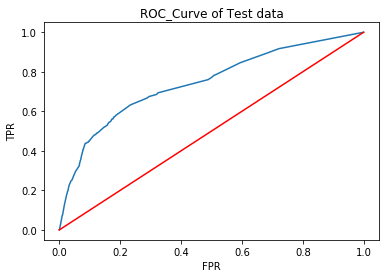

AUC of train:  0.7743993292924516


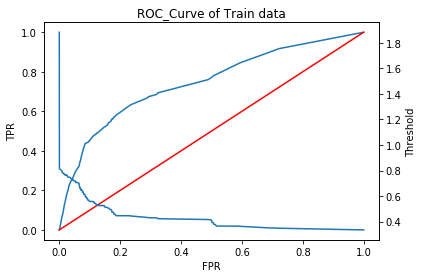

AUC of test:  0.7439813928571428


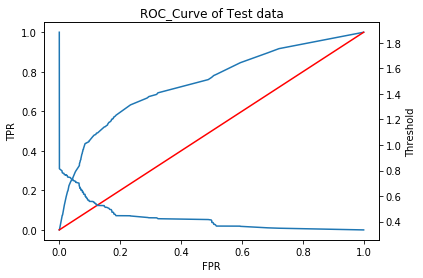

In [76]:
rfc = RandomForestClassifier(**rand_search_rfc.best_params_)

rfc.fit(X_train_sm, y_train_sm)

y_pred_train = rfc.predict(X_train_sm)
y_prob_train = rfc.predict_proba(X_train_sm)[:,1]

y_pred_test = rfc.predict(X_test)
y_prob_test = rfc.predict_proba(X_test)[:,1]

from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve

print('Accuracy of Random Forest_train: ', accuracy_score(y_pred_train, y_train_sm))
print('Accuracy of Random Forest_test: ', accuracy_score(y_pred_test, y_test))

print('AUC of Random Forest_train: ', roc_auc_score(y_train_sm, y_prob_train))
print('AUC of Random Forest_test: ', roc_auc_score(y_test, y_prob_test))

#Classification for test
print(classification_report(y_test,y_pred_test))

#classification for train
print(classification_report(y_train_sm,y_pred_train))

from sklearn.metrics import roc_auc_score, roc_curve

print('AUC of train: ', roc_auc_score(y_train_sm, y_prob_train)) #for train data

fpr, tpr, thresholds = roc_curve(y_train_sm, y_prob_train)

plt.plot(fpr, tpr)
plt.plot(fpr, fpr, 'r-')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC_Curve of Train data')
plt.show()

print('AUC of test: ', roc_auc_score(y_test, y_prob_test)) #for test data

fpr, tpr, thresholds = roc_curve(y_test, y_prob_test)

plt.plot(fpr, tpr)
plt.plot(fpr, fpr, 'r-')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC_Curve of Test data')
plt.show()


print('AUC of train: ', roc_auc_score(y_train_sm, y_prob_train)) #for train data

fig, ax = plt.subplots()

ax.plot(fpr, tpr) #blue color
ax.plot(fpr, fpr, 'r-') #red color
plt.xlabel('FPR')
plt.ylabel('TPR')
ax1 = ax.twinx()
ax1.plot(fpr,thresholds) 
ax1.set_ylabel('Threshold')

plt.title('ROC_Curve of Train data')
plt.show()

print('AUC of test: ', roc_auc_score(y_test, y_prob_test)) #for train data

fig, ax = plt.subplots()

ax.plot(fpr, tpr) #blue color
ax.plot(fpr, fpr, 'r-') #red color
plt.xlabel('FPR')
plt.ylabel('TPR')
ax1 = ax.twinx()
ax1.plot(fpr,thresholds) 
ax1.set_ylabel('Threshold')

plt.title('ROC_Curve of Test data')
plt.show()

In [77]:
#classification for train
print('Classification Report for Train dataset:')
print(classification_report(y_train_sm,y_pred_train))

Classification Report for Train dataset:
              precision    recall  f1-score   support

           0       0.65      0.83      0.73     16364
           1       0.77      0.55      0.64     16364

    accuracy                           0.69     32728
   macro avg       0.71      0.69      0.69     32728
weighted avg       0.71      0.69      0.69     32728



In [78]:
c={'precision':[0.64,0.80,'',0.72,0.72],'recall':[0.88,0.50,'',0.69,0.69],
  'f1-score':[0.74,0.62,0.69,0.68,0.68],'support':[16364,16364,32728,32728,32728]}
print('Classification Report for Train dataset:')
pd.DataFrame(data=c,index=['0','1','accuracy','macro avg','weighted avg'])

Classification Report for Train dataset:


precision recall  f1-score  support
0                 0.64   0.88      0.74    16364
1                  0.8    0.5      0.62    16364
accuracy                           0.69    32728
macro avg         0.72   0.69      0.68    32728
weighted avg      0.72   0.69      0.68    32728

In [79]:
#classification for test
print('Classification Report for Test dataset:')
print(classification_report(y_test,y_pred_test))

Classification Report for Test dataset:
              precision    recall  f1-score   support

           0       0.87      0.84      0.85      7000
           1       0.49      0.54      0.51      2000

    accuracy                           0.77      9000
   macro avg       0.68      0.69      0.68      9000
weighted avg       0.78      0.77      0.78      9000



In [80]:
c={'precision':[0.86,0.53,'',0.69,0.78],'recall':[0.88,0.48,'',0.68,0.79],
  'f1-score':[0.87,0.51,0.79,0.69,0.79],'support':[7000,2000,9000,9000,9000]}
print('Classification Report for Test dataset:')
pd.DataFrame(data=c,index=['0','1','accuracy','macro avg','weighted avg'])

Classification Report for Test dataset:


precision recall  f1-score  support
0                 0.86   0.88      0.87     7000
1                 0.53   0.48      0.51     2000
accuracy                           0.79     9000
macro avg         0.69   0.68      0.69     9000
weighted avg      0.78   0.79      0.79     9000

In [81]:
print('Confusion Matrix for Train dataset:')
print(confusion_matrix(y_train_sm,y_pred_train))

Confusion Matrix for Train dataset:
[[13633  2731]
 [ 7351  9013]]


In [82]:
print('Confusion Matrix for Test dataset:')
print(confusion_matrix(y_test,y_pred_test))

Confusion Matrix for Test dataset:
[[5856 1144]
 [ 911 1089]]


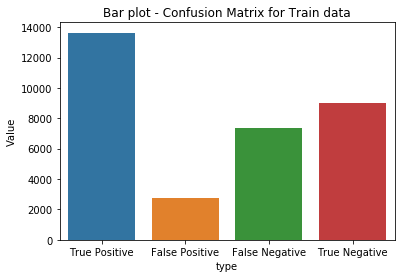

In [83]:
#plotting using confusion matrix 
d={'type': ['True Positive','False Positive','False Negative','True Negative'],
   'Value':[confusion_matrix(y_train_sm,y_pred_train)[0][0],
            confusion_matrix(y_train_sm,y_pred_train)[0][1],
             confusion_matrix(y_train_sm,y_pred_train)[1][0],
              confusion_matrix(y_train_sm,y_pred_train)[1][1]]}
d=pd.DataFrame(data=d)
sns.barplot(x='type',y='Value',data=d)
plt.title('Bar plot - Confusion Matrix for Train data')
plt.show()

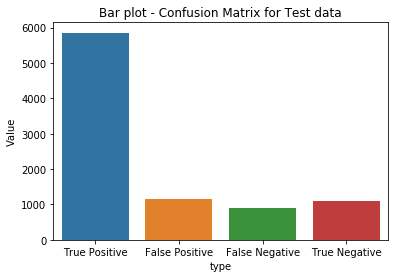

In [84]:
#plotting using confusion matrix 
d={'type': ['True Positive','False Positive','False Negative','True Negative'],
   'Value':[confusion_matrix(y_test,y_pred_test)[0][0],
            confusion_matrix(y_test,y_pred_test)[0][1],
            confusion_matrix(y_test,y_pred_test)[1][0],
            confusion_matrix(y_test,y_pred_test)[1][1]]}
d=pd.DataFrame(data=d)
sns.barplot(x='type',y='Value',data=d)
plt.title('Bar plot - Confusion Matrix for Test data')
plt.show()

### LGBM:

In [85]:
import lightgbm as lgb
lgbc = lgb.LGBMClassifier()

lgbc.fit(X_train_sm, y_train_sm)

y_pred_test = lgbc.predict(X_test)
y_prob_test = lgbc.predict_proba(X_test)[:,1]

y_pred_train = lgbc.predict(X_train_sm)
y_prob_train = lgbc.predict_proba(X_train_sm)[:,1]

print('Accuracy on Train Set: ', accuracy_score(y_train_sm, y_pred_train))
print('Accuracy on Test Set: ', accuracy_score(y_test, y_pred_test))
print('AUC of Train Set: ', roc_auc_score(y_train_sm, y_prob_train))
print('AUC of Test Set: ', roc_auc_score(y_test, y_prob_test))

#Classification for test
print(classification_report(y_test,y_pred_test))
print(classification_report(y_train_sm,y_pred_train))


Accuracy on Train Set:  0.8468589586898069
Accuracy on Test Set:  0.7723333333333333
AUC of Train Set:  0.929520490543867
AUC of Test Set:  0.7536481071428571
              precision    recall  f1-score   support

           0       0.85      0.85      0.85      7000
           1       0.49      0.49      0.49      2000

    accuracy                           0.77      9000
   macro avg       0.67      0.67      0.67      9000
weighted avg       0.77      0.77      0.77      9000

              precision    recall  f1-score   support

           0       0.82      0.88      0.85     16364
           1       0.87      0.81      0.84     16364

    accuracy                           0.85     32728
   macro avg       0.85      0.85      0.85     32728
weighted avg       0.85      0.85      0.85     32728



### LGBM with Tuning

In [86]:
from sklearn.model_selection import RandomizedSearchCV

from scipy.stats import randint as sp_randint

lgbc = lgb.LGBMClassifier(random_state=1)

params = {'n_estimators': sp_randint(5,100),
          'max_depth' : sp_randint(2,20),
          'min_child_samples' : sp_randint(1,20),
          'num_leaves' : sp_randint(5,20)}

rand_search_lgbc = RandomizedSearchCV(lgbc, param_distributions=params, random_state=1, cv=3)

rand_search_lgbc.fit(X_train_sm, y_train_sm)

rand_search_lgbc.best_params_

{'max_depth': 7, 'min_child_samples': 19, 'n_estimators': 89, 'num_leaves': 16}

Accuracy on Train Set:  0.816792960156441
Accuracy on Test Set:  0.7673333333333333
AUC of Train Set:  0.8988513487554373
AUC of Test Set:  0.7519403928571429
              precision    recall  f1-score   support

           0       0.86      0.84      0.85      7000
           1       0.48      0.51      0.49      2000

    accuracy                           0.77      9000
   macro avg       0.67      0.68      0.67      9000
weighted avg       0.77      0.77      0.77      9000

              precision    recall  f1-score   support

           0       0.79      0.86      0.82     16364
           1       0.85      0.78      0.81     16364

    accuracy                           0.82     32728
   macro avg       0.82      0.82      0.82     32728
weighted avg       0.82      0.82      0.82     32728

AUC of train:  0.8988513487554373


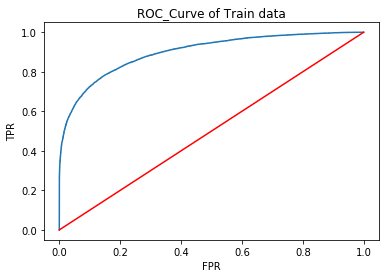

AUC of test:  0.7519403928571429


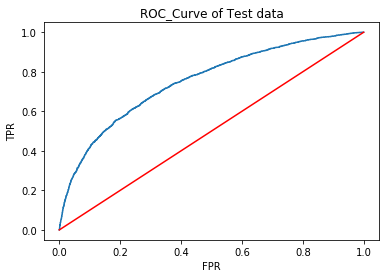

AUC of train:  0.8988513487554373


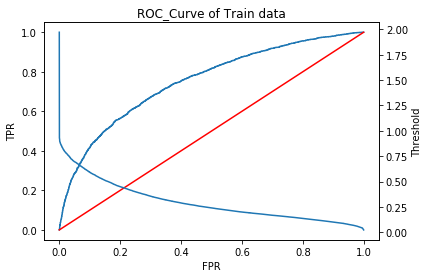

AUC of test:  0.7519403928571429


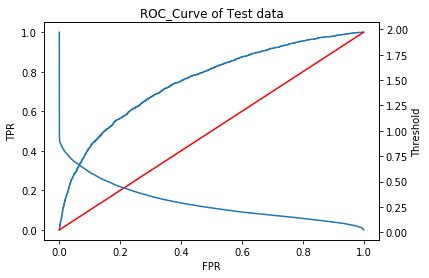

In [87]:
lgbc = lgb.LGBMClassifier(**rand_search_lgbc.best_params_, random_state=1)

lgbc.fit(X_train_sm, y_train_sm)

y_pred_test = lgbc.predict(X_test)
y_prob_test = lgbc.predict_proba(X_test)[:,1]

y_pred_train = lgbc.predict(X_train_sm)
y_prob_train = lgbc.predict_proba(X_train_sm)[:,1]

print('Accuracy on Train Set: ', accuracy_score(y_train_sm, y_pred_train))
print('Accuracy on Test Set: ', accuracy_score(y_test, y_pred_test))
print('AUC of Train Set: ', roc_auc_score(y_train_sm, y_prob_train))
print('AUC of Test Set: ', roc_auc_score(y_test, y_prob_test))

#Classification for test
print(classification_report(y_test,y_pred_test))
print(classification_report(y_train_sm,y_pred_train))

print('AUC of train: ', roc_auc_score(y_train_sm, y_prob_train)) #for train data

fpr, tpr, thresholds = roc_curve(y_train_sm, y_prob_train)

plt.plot(fpr, tpr)
plt.plot(fpr, fpr, 'r-')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC_Curve of Train data')
plt.show()

print('AUC of test: ', roc_auc_score(y_test, y_prob_test)) #for test data

fpr, tpr, thresholds = roc_curve(y_test, y_prob_test)

plt.plot(fpr, tpr)
plt.plot(fpr, fpr, 'r-')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC_Curve of Test data')
plt.show()


print('AUC of train: ', roc_auc_score(y_train_sm, y_prob_train)) #for train data

fig, ax = plt.subplots()

ax.plot(fpr, tpr) #blue color
ax.plot(fpr, fpr, 'r-') #red color
plt.xlabel('FPR')
plt.ylabel('TPR')
ax1 = ax.twinx()
ax1.plot(fpr,thresholds) 
ax1.set_ylabel('Threshold')

plt.title('ROC_Curve of Train data')
plt.show()

print('AUC of test: ', roc_auc_score(y_test, y_prob_test)) #for train data

fig, ax = plt.subplots()

ax.plot(fpr, tpr) #blue color
ax.plot(fpr, fpr, 'r-') #red color
plt.xlabel('FPR')
plt.ylabel('TPR')
ax1 = ax.twinx()
ax1.plot(fpr,thresholds) 
ax1.set_ylabel('Threshold')

plt.title('ROC_Curve of Test data')
plt.show()

### Naive Bayes:

In [88]:
from sklearn.naive_bayes import BernoulliNB
bnb = BernoulliNB()

bnb.fit(X_train_sm, y_train_sm)

y_pred_train = bnb.predict(X_train_sm)
y_prob_train = bnb.predict_proba(X_train_sm)[:,1]

y_pred_test = bnb.predict(X_test)
y_prob_test = bnb.predict_proba(X_test)[:,1]

from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve

print('Accuracy of Bayes_train: ', accuracy_score(y_pred_train, y_train_sm))
print('Accuracy of Bayes_test: ', accuracy_score(y_pred, y_test))

print('AUC of Bayes_train: ', roc_auc_score(y_train_sm, y_prob_train))
print('AUC of Bayes_test: ', roc_auc_score(y_test, y_prob_test))

#Classification for test
print(classification_report(y_test,y_pred))

#classification for train
print(classification_report(y_train_sm,y_pred_train))

Accuracy of Bayes_train:  0.6614825226106087
Accuracy of Bayes_test:  0.8182222222222222
AUC of Bayes_train:  0.7145618738416258
AUC of Bayes_test:  0.7077092500000001
              precision    recall  f1-score   support

           0       0.84      0.95      0.89      7000
           1       0.67      0.35      0.46      2000

    accuracy                           0.82      9000
   macro avg       0.76      0.65      0.68      9000
weighted avg       0.80      0.82      0.80      9000

              precision    recall  f1-score   support

           0       0.62      0.85      0.72     16364
           1       0.76      0.47      0.58     16364

    accuracy                           0.66     32728
   macro avg       0.69      0.66      0.65     32728
weighted avg       0.69      0.66      0.65     32728



# KNN:

In [89]:

knn=KNeighborsClassifier()
knn.fit(X_train_sm,y_train_sm)

y_pred_train = knn.predict(X_train_sm)
y_prob_train = knn.predict_proba(X_train_sm)[:,1]

y_pred_test = knn.predict(X_test)
y_prob_test = knn.predict_proba(X_test)[:,1]

from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve

print('Accuracy of Bayes_train: ', accuracy_score(y_pred_train, y_train_sm))
print('Accuracy of Bayes_test: ', accuracy_score(y_pred, y_test))

print('AUC of Bayes_train: ', roc_auc_score(y_train_sm, y_prob_train))
print('AUC of Bayes_test: ', roc_auc_score(y_test, y_prob_test))

#Classification for test
print(classification_report(y_test,y_pred_test))

#classification for train
print(classification_report(y_train_sm,y_pred_train))

Accuracy of Bayes_train:  0.8394646785626986
Accuracy of Bayes_test:  0.8182222222222222
AUC of Bayes_train:  0.9509016537933368
AUC of Bayes_test:  0.5847690357142858
              precision    recall  f1-score   support

           0       0.82      0.61      0.70      7000
           1       0.28      0.52      0.36      2000

    accuracy                           0.59      9000
   macro avg       0.55      0.56      0.53      9000
weighted avg       0.70      0.59      0.62      9000

              precision    recall  f1-score   support

           0       0.95      0.72      0.82     16364
           1       0.77      0.96      0.86     16364

    accuracy                           0.84     32728
   macro avg       0.86      0.84      0.84     32728
weighted avg       0.86      0.84      0.84     32728



#### Tunning:

In [90]:
knn=KNeighborsClassifier()

params ={'n_neighbors':sp_randint(5,30),
         'p':sp_randint(1,5)}

rand_search_knn=RandomizedSearchCV(knn,param_distributions=params,cv=3,random_state=1)

rand_search_knn.fit(X,y)
rand_search_knn.best_params_

{'n_neighbors': 23, 'p': 1}

In [91]:
knn=KNeighborsClassifier(**rand_search_knn.best_params_)

knn.fit(X_train_sm,y_train_sm)

y_pred_train = knn.predict(X_train_sm)
y_prob_train = knn.predict_proba(X_train_sm)[:,1]

y_pred_test = knn.predict(X_test)
y_prob_test = knn.predict_proba(X_test)[:,1]

from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve

print('Accuracy of Bayes_train: ', accuracy_score(y_pred_train, y_train_sm))
print('Accuracy of Bayes_test: ', accuracy_score(y_pred, y_test))

print('AUC of Bayes_train: ', roc_auc_score(y_train_sm, y_prob_train))
print('AUC of Bayes_test: ', roc_auc_score(y_test, y_prob_test))

#Classification for test
print(classification_report(y_test,y_pred_test))

#classification for train
print(classification_report(y_train_sm,y_pred_train))

Accuracy of Bayes_train:  0.7182534832559276
Accuracy of Bayes_test:  0.8182222222222222
AUC of Bayes_train:  0.8131808972375643
AUC of Bayes_test:  0.6369073928571429
              precision    recall  f1-score   support

           0       0.85      0.55      0.66      7000
           1       0.29      0.65      0.40      2000

    accuracy                           0.57      9000
   macro avg       0.57      0.60      0.53      9000
weighted avg       0.72      0.57      0.61      9000

              precision    recall  f1-score   support

           0       0.80      0.58      0.67     16364
           1       0.67      0.85      0.75     16364

    accuracy                           0.72     32728
   macro avg       0.74      0.72      0.71     32728
weighted avg       0.74      0.72      0.71     32728



### Adaboost

In [92]:
# using adaboost
ada = AdaBoostClassifier(n_estimators=100)
ada.fit(X_train_sm,y_train_sm)
y_pred = ada.predict(X_test)
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))
y_pred_train = ada.predict(X_train)
print(classification_report(y_train,y_pred_train))

0.7341111111111112
              precision    recall  f1-score   support

           0       0.86      0.79      0.82      7000
           1       0.42      0.54      0.48      2000

    accuracy                           0.73      9000
   macro avg       0.64      0.67      0.65      9000
weighted avg       0.76      0.73      0.75      9000

              precision    recall  f1-score   support

           0       0.86      0.80      0.83     16364
           1       0.44      0.56      0.49      4636

    accuracy                           0.75     21000
   macro avg       0.65      0.68      0.66     21000
weighted avg       0.77      0.75      0.76     21000



### GradientBoost

In [93]:
# using Gradientboost
grad = GradientBoostingClassifier()
grad.fit(X_train_sm,y_train_sm)
y_pred = grad.predict(X_test)
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))
y_pred_train = grad.predict(X_train)
print(classification_report(y_train,y_pred_train))

0.7591111111111111
              precision    recall  f1-score   support

           0       0.86      0.82      0.84      7000
           1       0.46      0.55      0.50      2000

    accuracy                           0.76      9000
   macro avg       0.66      0.68      0.67      9000
weighted avg       0.78      0.76      0.77      9000

[[5735 1265]
 [ 903 1097]]
              precision    recall  f1-score   support

           0       0.87      0.83      0.85     16364
           1       0.49      0.57      0.52      4636

    accuracy                           0.77     21000
   macro avg       0.68      0.70      0.69     21000
weighted avg       0.79      0.77      0.78     21000

